In [1]:
# Importamos los paquetes necesarios
# Python ≥3.5
import sys
assert sys.version_info >= (3, 5)

import numpy as np
import os
import seaborn as sns
import pandas as pd
import math

%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.patches import Patch

mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)
from pandas.plotting import scatter_matrix

# Scikit-Learn ≥0.20
import sklearn
assert sklearn.__version__ >= "0.20"


import matplotlib.pyplot as plt
from zlib import crc32
import hashlib
import matplotlib.image as mpimg
from sklearn.model_selection import train_test_split
from six.moves import urllib
from scipy import stats
from sklearn.metrics import mean_squared_error
from sklearn import metrics
from sklearn import linear_model
from sklearn.pipeline import Pipeline
from sklearn.model_selection import (TimeSeriesSplit, KFold, ShuffleSplit,
StratifiedKFold, GroupShuffleSplit, GridSearchCV, train_test_split,
GroupKFold, StratifiedShuffleSplit,cross_val_score)
from sklearn.linear_model import Ridge
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import (StandardScaler,RobustScaler,OrdinalEncoder,OneHotEncoder,PolynomialFeatures)
from sklearn.compose import ColumnTransformer
from sklearn.neighbors import LocalOutlierFactor
from sklearn import svm
from sklearn.metrics import (classification_report, confusion_matrix,hinge_loss)
import pdpipe as pdp

# Donde guardar las figuras
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "end_to_end_project"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

#### Linear SVM Classification
Se puede pensar al Support Vector Machine como un clasificador que entrena con la separación entre clases lo más ancha posible _large margin classification_.

En este modelo agregar instancias fuera de la separación entre clases no va a afectar la superficie de decisión.

Los Support vectors son aquellos que se se obtienen de las instancias localizadas en los bordes de la separación

Dato: SVM es sencible a la escala de los atributos.

- _Hard margin classification_ : Solamente funciona si los datos son linealmente separables. Segundo, es sensible a outliers
- _Soft margin classification_ : Es un balance entre limitar las violaciones de los margenes y mantener el margen lo más ancho posible.
    - En Scikit-Learn se pueden especificar C para eso. 
        - C >> : implica una mayor restricción de la violacion a los margenes.
        - C << : implica maximizar el ancho de la separación entre clases.
    - Matematicamente implica utilizar la Hinge-Loss de manera que penalice más los errores de clasificación que las instancias que quedaron dentro de las bandas: 
    $$max(0, 1 - y_i(w^t x_i + w_0))$$
    - Para aplicar Soft margin intentamos minimizar la formula:
        $$ C||w||^2 + \frac{1}{N}\sum_{i=1}^{N} max(0, 1 - y_i(w^t x_i + w_0))$$
        Donde C es un hiperparametro que se debe "tunnear" para elegir que priorizamos en la minimización si el máximo ancho de bandas o la penalización de las miss classification's

De la interpretación de SVM para Hard-Margin se puede reformular como un problema de optimización usando multiplicadores de Lagrange. A partir de exta expresión con dos condiciones podemos obtener una formulación _Dual_ del problema:
   - Solamente expresada en terminos de productos internos, lo cual favorece la utilización de kernels 
   - Mucho más performante para la utilización de datasets donde la cantidad de variables es mayor al número de muestras. 

### South African Heart Desease Dataset 
A continuación vamos a explorar los datos que provienen del dataset a utilizar en este trabajo práctico

In [2]:
saheart_df = pd.read_csv("data/SouthAfricanHeartDesease.csv");
saheart_df.head();

#nombres de las columnas separados por uso
numeric_cols = ['sbp','tobacco','ldl','adiposity','typea','obesity','alcohol','age']

categorical_cols = ['famhist']
target_feature = 'chd'

#removemos la columna row.names que solo posee el índice de cada fila
saheart_df = saheart_df.drop("row.names", axis=1)
df_target = saheart_df.chd
#head del dataset
saheart_df.head()

,sbp,tobacco,ldl,adiposity,famhist,typea,obesity,alcohol,age,chd
0,160,12.00,5.73,23.11,Present,49,25.30,97.20,52,1
1,144,0.01,4.41,28.61,Absent,55,28.87,2.06,63,1
2,118,0.08,3.48,32.28,Present,52,29.14,3.81,46,0
3,170,7.50,6.41,38.03,Present,51,31.99,24.26,58,1
4,134,13.60,3.50,27.78,Present,60,25.99,57.34,49,1


In [3]:
saheart_df.info()
print("Cantidad de entradas con enfermedad: "+str(len(saheart_df[saheart_df['chd']==1])))
print("Cantidad de entradas sin enfermedad: "+str(len(saheart_df[saheart_df['chd']==0])))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 462 entries, 0 to 461
Data columns (total 10 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   sbp        462 non-null    int64  
 1   tobacco    462 non-null    float64
 2   ldl        462 non-null    float64
 3   adiposity  462 non-null    float64
 4   famhist    462 non-null    object 
 5   typea      462 non-null    int64  
 6   obesity    462 non-null    float64
 7   alcohol    462 non-null    float64
 8   age        462 non-null    int64  
 9   chd        462 non-null    int64  
dtypes: float64(5), int64(4), object(1)
memory usage: 36.2+ KB
Cantidad de entradas con enfermedad: 160
Cantidad de entradas sin enfermedad: 302


In [ ]:
#Distribuciones de las features a utilizar
sns.pairplot(saheart_df, hue = target_feature) \
.add_legend();

### Exploramos la documentación de scikit learn con los modelos que vamos a poder utilizar

#### [Unbalanced problems](https://scikit-learn.org/stable/modules/svm.html#unbalanced-problems)
Es una sección interesante que encontre en la docu de scikit. Menciona que hay unos parametros, class_weight y sample_weight que te permiten darle más importancia a ciertas clases o muestras en particular. Tal vez en nuestro caso no nos sriva de mucho pero está bueno para explorar.

#### [Linear Support Vector Classifier](https://scikit-learn.org/stable/modules/generated/sklearn.svm.LinearSVC.html#sklearn.svm.LinearSVC)
Es similar al Support vector classifier que provee scikit learn solamente que su implementación se basa en [liblinear](https://www.csie.ntu.edu.tw/~cjlin/liblinear/) en lugar de [libsvm](https://www.csie.ntu.edu.tw/~cjlin/papers/libsvm.pdf). Este se recomienda para la utilización de datasets más grandes.
Considerando que nuestro dataset no posee un gran número de entradas y que con el modelo SVC tambien podemos aplicar un kernel lineal descartamos la utilización de este modelo.
[Acá tenemos su formulación](https://scikit-learn.org/stable/modules/svm.html#linearsvc)


#### [Support vector classifier](https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html#sklearn.svm.SVC)
La implementación de este modelo está basada en [libsvm](https://www.csie.ntu.edu.tw/~cjlin/papers/libsvm.pdf). 
The fit time scales at least quadratically with the number of samples and may be impractical beyond tens of thousands of samples. For large datasets consider using LinearSVC.
[Acá tenemos su formulación](https://scikit-learn.org/stable/modules/svm.html#svc)


#### [One class support vector classifier](https://scikit-learn.org/stable/modules/generated/sklearn.svm.OneClassSVM.html#sklearn.svm.OneClassSVM)
Su implementación al igual que con SVC se basa en [libsvm](https://www.csie.ntu.edu.tw/~cjlin/papers/libsvm.pdf). Sin embargo este modelo utiliza unsupervised outlier detection lo cual no es aplicable dentro del contexto de este trabajo.

#### [Support vector classifier with control the number of support vectors](https://scikit-learn.org/stable/modules/generated/sklearn.svm.NuSVC.html#sklearn.svm.NuSVC)
Es similar a SVC pero usa un parametro extra _nu_ para controlar el numero de support vectors utilizados.
Su implementación está basada en [libsvm](https://www.csie.ntu.edu.tw/~cjlin/papers/libsvm.pdf).
[Acá tenemos su formulación](https://scikit-learn.org/stable/modules/svm.html#nusvc)

### [Tips de uso práctico para los modelos que nos provee scikit](https://scikit-learn.org/stable/modules/svm.html#shrinking-svm)
- Evitar la copia de datos: para SVC y NuSVC, si los datos pasados a ciertos métodos no son contiguos, ordenados en C y de doble precisión, se copiarán antes de llamar a la implementación de C subyacente. **Puede verificar si una matriz numérica dada es C-contigua inspeccionando su atributo flags.**

   Para LinearSVC, cualquier entrada pasada como una matriz numpy se copiará y convertirá a la representación de datos dispersos internos liblinear (flotantes de doble precisión e índices int32 de componentes distintos de cero).
   
- For SVC y NuSVC, el tamaño del kernel tiene un fuerte impacto en los tiempos de ejecución de problemas grandes. **If you have enough RAM available, it is recommended to set cache_size to a higher value than the default of 200(MB), such as 500(MB) or 1000(MB)**.

- Setting C: C is 1 by default and it’s a reasonable default choice. If you have a lot of noisy observations you should decrease it: decreasing C corresponds to more regularization.

  **LinearSVC are less sensitive to C when it becomes large, and prediction results stop improving after a certain threshold (podríamos buscar este threshold)**. Meanwhile, larger C values will take more time to train, sometimes up to 10 times longer, as shown in 11.

- Support Vector Machine algorithms are not scale invariant, so it is **highly recommended to scale your data**. For example, scale each attribute on the input vector X to [0,1] or [-1,+1], or standardize it to have mean 0 and variance 1. Note that the same scaling must be applied to the test vector to obtain meaningful results. This can be done easily by using a Pipeline

- Regarding the shrinking parameter (por lo que vi el OneClassSVM lo tiene), quoting 12: We found that if the number of iterations is large, then shrinking can shorten the training time. However, if we loosely solve the optimization problem (e.g., by using a large stopping tolerance), the code without using shrinking may be much faster

- Parameter nu in NuSVC/OneClassSVM approximates the fraction of training errors and support vectors.

- In SVC, if the data is unbalanced (e.g. many positive and few negative **esto nos esta pasando a nosotros**), set class_weight='balanced' and/or try different penalty parameters C.

- Aleatoriedad de las implementaciones subyacentes: las implementaciones subyacentes de SVC y NuSVC **usan un generador de números aleatorios solo para mezclar los datos en la estimación de probabilidad (cuando la probabilidad se establece en Verdadero). Esta aleatoriedad se puede controlar con el parámetro random_state. Si la probabilidad se establece en False, estos estimadores no son aleatorios y random_state no tiene ningún efecto sobre los resultados**. La implementación subyacente de OneClassSVM es similar a las de SVC y NuSVC. Como no se proporciona una estimación de probabilidad para OneClassSVM, no es aleatorio.

  La implementación subyacente de LinearSVC utiliza un generador de números aleatorios para seleccionar características cuando se ajusta el modelo con un descenso de coordenadas dual (es decir, cuando dual se establece en Verdadero). **Por lo tanto, no es raro tener resultados ligeramente diferentes para los mismos datos de entrada. Si eso sucede, intente con un parámetro tol más pequeño**. Esta aleatoriedad también se puede controlar con el parámetro random_state. Cuando dual se establece en False, la implementación subyacente de LinearSVC no es aleatoria y random_state no tiene ningún efecto en los resultados. 
  
- Using L1 penalization as provided by LinearSVC(penalty='l1', dual=False) yields a sparse solution, i.e. only a subset of feature weights is different from zero and contribute to the decision function. Increasing C yields a more complex model (more features are selected). The C value that yields a “null” model (all weights equal to zero) can be calculated using l1_min_c.

- Para las funciones de kernel en la documentación hay una explicación de la formulación de cada una y los parametros de RBF. [Acá](https://scikit-learn.org/stable/modules/svm.html#kernel-functions)


### Train Support vector classifier without hyper-parameter tunning
Primero vamos a entrenar el modelo SVC sin especificar ningún tipo de parámetro y sin hacer búsqueda de los mejores hiperparametros para luego contrastar el impacto de la búsqueda

In [8]:
#funciones auxiliares
def selectValuesForHyperparameter(initialValue, lastValue, jumps):
    rv = []
    for v in range(int(initialValue*100), int(lastValue*100),int(jumps*100)):
        rv.append(float(v/100));
    return rv 

def trainModels(data, target, fileExt):
    
    #train - test division
    X_train, X_test, y_train, y_test  = train_test_split(data, np.ravel(target) ,test_size=0.3, random_state=42)
    X_train = X_train.drop(target_feature, axis=1).copy()
    X_test = X_test.drop(target_feature, axis=1).copy()
    
    # defining parameter range
    print("Entrenamos Support vector classifier con kernel RBF\n")
    param_grid = {'C': [0.1, 0.5,1,10,50 ,100,1000], 
                  'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
                  'class_weight' : ['balanced', None]
                  }

    clf_rbf = GridSearchCV(svm.SVC(kernel='rbf',cache_size=1000), 
                        param_grid, refit = True, 
                        verbose = 3)

    # entrenamos el modelo con gridsearch
    clf_rbf.fit(X_train, y_train)

    print("Los mejores hiperparametros son :"+str(clf_rbf.best_params_)+"\n")
    print(clf_rbf.best_estimator_)
    clf_rbf_predictions = clf_rbf.predict(X_test)
    # print classification report
    print(classification_report(y_test, clf_rbf_predictions))
    results_rbf = pd.DataFrame(clf_rbf.cv_results_)
    results_rbf.to_csv('GridSearchResult_rbf_'+fileExt+'.csv')

    
    #=======================================================================
    
    print("Entrenamos Support vector classifier con kernel Sigmoideo\n")
    param_grid = {'C': [0.1, 0.5,1,10,50 ,100,1000], 
                  'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
                  'coef0' : selectValuesForHyperparameter(0,15,1.5),
                  'class_weight' : ['balanced', None]
                 }

    clf_sig = GridSearchCV(svm.SVC(kernel='sigmoid', cache_size=1000), 
                        param_grid, refit = True, 
                        verbose = 3)

    # entrenamos el modelo con gridsearch
    clf_sig.fit(X_train, y_train)

    print("Los mejores hiperparametros son :"+str(clf_sig.best_params_)+"\n")
    print(clf_sig.best_estimator_)
    clf_sig_predictions = clf_sig.predict(X_test)
    # print classification report
    print(classification_report(y_test, clf_sig_predictions))
    pd.DataFrame(clf_sig.cv_results_).to_csv('GridSearchResult_sig_'+fileExt+'.csv')
    
    #=======================================================================
    
    # defining parameter range
    print("Entrenamos Support vector classifier con kernel Lineal\n")
    param_grid = {'C': [0.01, 0.1, 0.5,1,10,50 ,100,1000],
                  'class_weight' : ['balanced', None]
                  }

    clf_lin = GridSearchCV(svm.SVC(kernel='linear',cache_size=1000), 
                        param_grid, refit = True, 
                        verbose = 3)

    # entrenamos el modelo con gridsearch
    clf_lin.fit(X_train, y_train)

    print("Los mejores hiperparametros son :"+str(clf_lin.best_params_)+"\n")
    print(clf_lin.best_estimator_)
    clf_lin_predictions = clf_lin.predict(X_test)
    # print classification report
    print(classification_report(y_test, clf_lin_predictions))
    results_lin = pd.DataFrame(clf_lin.cv_results_)
    results_lin.to_csv('GridSearchResult_lineal_'+fileExt+'.csv')
    
    return clf_rbf, clf_sig, clf_lin

def removeOutliers(data, factor):
    lof = LocalOutlierFactor(contamination=factor)
    dataOutliers = data[numeric_cols].copy()

    #predicción de outliers
    InOrOut = lof.fit_predict(dataOutliers)

    mask = InOrOut != -1
    mask_series = pd.Series(mask)
    print(np.unique(mask, return_counts=True))

    #filtrado de los outliers
    data_filtered = data[mask_series.values].copy()
    data_withoutOutliers =  data_filtered.reset_index(drop=True).copy()
    return data_withoutOutliers

def scaleData(data):
    scaler = StandardScaler()
    data[numeric_cols] = scaler.fit_transform(data[numeric_cols])
    return data

def scaleAndTransform(data):
    pipeline = pdp.OneHotEncode('famhist')
    #pipeline+= pdp.Scale('StandardScaler', exclude_columns = ['famhist','chd'])
    data_prepared = pipeline(data)
    data_prepared = scaleData(data_prepared)
    return data_prepared
    

In [9]:
#dropeamos la variable categorica
saheart = saheart_df.drop('famhist', axis=1).copy()
#train - test division
X_train, X_test, y_train, y_test  = train_test_split(saheart, saheart.chd ,test_size=0.3, random_state=42)
X_train = X_train.drop(target_feature, axis=1).copy()
X_test = X_test.drop(target_feature, axis=1).copy()
# entrenamos el modelo con el train set
model = svm.SVC()
model.fit(X_train, y_train)
  
# mostramos los resultados
predictions = model.predict(X_test)
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

           0       0.65      0.97      0.78        90
           1       0.50      0.06      0.11        49

    accuracy                           0.65       139
   macro avg       0.58      0.51      0.44       139
weighted avg       0.60      0.65      0.54       139



In [ ]:
    #train - test division
    X_train, X_test, y_train, y_test  = train_test_split(saheart, saheart.chd ,test_size=0.3, random_state=42)
    X_train = X_train.drop(target_feature, axis=1).copy()
    X_test = X_test.drop(target_feature, axis=1).copy()
    
    
    print("Entrenamos Support vector classifier con kernel Polinomial\n")
    param_grid = {'C': [0.1, 0.5,1,10,50 ,100,1000], 
                  'degree': selectValuesForHyperparameter(0,10,1),
                  'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
                  'kernel': ['poly'],
                  'coef0' : selectValuesForHyperparameter(0,9,1.5)}

    clf_poly = GridSearchCV(svm.SVC(cache_size=1000,
                        class_weight='balanced', shrinking = True), 
                        param_grid, refit = True, 
                        verbose = 3)

    # entrenamos el modelo con gridsearch
    clf_poly.fit(X_train, y_train)

    print("Los mejores hiperparametros son :"+str(clf_poly.best_params_)+"\n")
    print(clf_poly.best_estimator_)
    clf_poly_predictions = clf_poly.predict(X_test)
    # print classification report
    print(classification_report(y_test, clf_poly_predictions))
    results_poly = pd.DataFrame(clf_poly.cv_results_)
    results_poly.to_csv('GridSearchResult_poly_'+fileExt+'.csv')

Entrenamos Support vector classifier con kernel Polinomial

Fitting 5 folds for each of 2100 candidates, totalling 10500 fits
[CV 1/5] END C=0.1, coef0=0.0, degree=0.0, gamma=1, kernel=poly;, score=0.646 total time=   0.0s
[CV 2/5] END C=0.1, coef0=0.0, degree=0.0, gamma=1, kernel=poly;, score=0.662 total time=   0.0s
[CV 3/5] END C=0.1, coef0=0.0, degree=0.0, gamma=1, kernel=poly;, score=0.662 total time=   0.0s
[CV 4/5] END C=0.1, coef0=0.0, degree=0.0, gamma=1, kernel=poly;, score=0.344 total time=   0.0s
[CV 5/5] END C=0.1, coef0=0.0, degree=0.0, gamma=1, kernel=poly;, score=0.344 total time=   0.0s
[CV 1/5] END C=0.1, coef0=0.0, degree=0.0, gamma=0.1, kernel=poly;, score=0.646 total time=   0.0s
[CV 2/5] END C=0.1, coef0=0.0, degree=0.0, gamma=0.1, kernel=poly;, score=0.662 total time=   0.0s
[CV 3/5] END C=0.1, coef0=0.0, degree=0.0, gamma=0.1, kernel=poly;, score=0.662 total time=   0.0s
[CV 4/5] END C=0.1, coef0=0.0, degree=0.0, gamma=0.1, kernel=poly;, score=0.344 total time= 

In [25]:
rbf_withoutFH, sig_withoutFH, lin_withoutFH = trainModels(saheart, saheart.chd, "withoutCategorical")

Entrenamos Support vector classifier con kernel RBF

Fitting 5 folds for each of 35 candidates, totalling 175 fits
[CV 1/5] END ....................C=0.1, gamma=1;, score=0.646 total time=   0.0s
[CV 2/5] END ....................C=0.1, gamma=1;, score=0.662 total time=   0.0s
[CV 3/5] END ....................C=0.1, gamma=1;, score=0.662 total time=   0.0s
[CV 4/5] END ....................C=0.1, gamma=1;, score=0.656 total time=   0.0s
[CV 5/5] END ....................C=0.1, gamma=1;, score=0.656 total time=   0.0s
[CV 1/5] END ..................C=0.1, gamma=0.1;, score=0.646 total time=   0.0s
[CV 2/5] END ..................C=0.1, gamma=0.1;, score=0.662 total time=   0.0s
[CV 3/5] END ..................C=0.1, gamma=0.1;, score=0.662 total time=   0.0s
[CV 4/5] END ..................C=0.1, gamma=0.1;, score=0.656 total time=   0.0s
[CV 5/5] END ..................C=0.1, gamma=0.1;, score=0.656 total time=   0.0s
[CV 1/5] END .................C=0.1, gamma=0.01;, score=0.646 total time=  

[CV 1/5] END ................C=50, gamma=0.0001;, score=0.754 total time=   0.0s
[CV 2/5] END ................C=50, gamma=0.0001;, score=0.677 total time=   0.0s
[CV 3/5] END ................C=50, gamma=0.0001;, score=0.646 total time=   0.0s
[CV 4/5] END ................C=50, gamma=0.0001;, score=0.578 total time=   0.0s
[CV 5/5] END ................C=50, gamma=0.0001;, score=0.719 total time=   0.0s
[CV 1/5] END ....................C=100, gamma=1;, score=0.646 total time=   0.0s
[CV 2/5] END ....................C=100, gamma=1;, score=0.662 total time=   0.0s
[CV 3/5] END ....................C=100, gamma=1;, score=0.662 total time=   0.0s
[CV 4/5] END ....................C=100, gamma=1;, score=0.656 total time=   0.0s
[CV 5/5] END ....................C=100, gamma=1;, score=0.656 total time=   0.0s
[CV 1/5] END ..................C=100, gamma=0.1;, score=0.646 total time=   0.0s
[CV 2/5] END ..................C=100, gamma=0.1;, score=0.662 total time=   0.0s
[CV 3/5] END ...............

[CV 5/5] END .....C=0.1, coef0=3.0, gamma=0.001;, score=0.656 total time=   0.0s
[CV 1/5] END ....C=0.1, coef0=3.0, gamma=0.0001;, score=0.646 total time=   0.0s
[CV 2/5] END ....C=0.1, coef0=3.0, gamma=0.0001;, score=0.662 total time=   0.0s
[CV 3/5] END ....C=0.1, coef0=3.0, gamma=0.0001;, score=0.662 total time=   0.0s
[CV 4/5] END ....C=0.1, coef0=3.0, gamma=0.0001;, score=0.656 total time=   0.0s
[CV 5/5] END ....C=0.1, coef0=3.0, gamma=0.0001;, score=0.656 total time=   0.0s
[CV 1/5] END .........C=0.1, coef0=4.5, gamma=1;, score=0.646 total time=   0.0s
[CV 2/5] END .........C=0.1, coef0=4.5, gamma=1;, score=0.662 total time=   0.0s
[CV 3/5] END .........C=0.1, coef0=4.5, gamma=1;, score=0.662 total time=   0.0s
[CV 4/5] END .........C=0.1, coef0=4.5, gamma=1;, score=0.656 total time=   0.0s
[CV 5/5] END .........C=0.1, coef0=4.5, gamma=1;, score=0.656 total time=   0.0s
[CV 1/5] END .......C=0.1, coef0=4.5, gamma=0.1;, score=0.646 total time=   0.0s
[CV 2/5] END .......C=0.1, c

[CV 3/5] END ....C=0.1, coef0=10.5, gamma=0.001;, score=0.662 total time=   0.0s
[CV 4/5] END ....C=0.1, coef0=10.5, gamma=0.001;, score=0.656 total time=   0.0s
[CV 5/5] END ....C=0.1, coef0=10.5, gamma=0.001;, score=0.656 total time=   0.0s
[CV 1/5] END ...C=0.1, coef0=10.5, gamma=0.0001;, score=0.646 total time=   0.0s
[CV 2/5] END ...C=0.1, coef0=10.5, gamma=0.0001;, score=0.662 total time=   0.0s
[CV 3/5] END ...C=0.1, coef0=10.5, gamma=0.0001;, score=0.662 total time=   0.0s
[CV 4/5] END ...C=0.1, coef0=10.5, gamma=0.0001;, score=0.656 total time=   0.0s
[CV 5/5] END ...C=0.1, coef0=10.5, gamma=0.0001;, score=0.656 total time=   0.0s
[CV 1/5] END ........C=0.1, coef0=12.0, gamma=1;, score=0.646 total time=   0.0s
[CV 2/5] END ........C=0.1, coef0=12.0, gamma=1;, score=0.662 total time=   0.0s
[CV 3/5] END ........C=0.1, coef0=12.0, gamma=1;, score=0.662 total time=   0.0s
[CV 4/5] END ........C=0.1, coef0=12.0, gamma=1;, score=0.656 total time=   0.0s
[CV 5/5] END ........C=0.1, 

[CV 2/5] END ....C=0.5, coef0=3.0, gamma=0.0001;, score=0.662 total time=   0.0s
[CV 3/5] END ....C=0.5, coef0=3.0, gamma=0.0001;, score=0.662 total time=   0.0s
[CV 4/5] END ....C=0.5, coef0=3.0, gamma=0.0001;, score=0.656 total time=   0.0s
[CV 5/5] END ....C=0.5, coef0=3.0, gamma=0.0001;, score=0.656 total time=   0.0s
[CV 1/5] END .........C=0.5, coef0=4.5, gamma=1;, score=0.646 total time=   0.0s
[CV 2/5] END .........C=0.5, coef0=4.5, gamma=1;, score=0.662 total time=   0.0s
[CV 3/5] END .........C=0.5, coef0=4.5, gamma=1;, score=0.662 total time=   0.0s
[CV 4/5] END .........C=0.5, coef0=4.5, gamma=1;, score=0.656 total time=   0.0s
[CV 5/5] END .........C=0.5, coef0=4.5, gamma=1;, score=0.656 total time=   0.0s
[CV 1/5] END .......C=0.5, coef0=4.5, gamma=0.1;, score=0.646 total time=   0.0s
[CV 2/5] END .......C=0.5, coef0=4.5, gamma=0.1;, score=0.662 total time=   0.0s
[CV 3/5] END .......C=0.5, coef0=4.5, gamma=0.1;, score=0.662 total time=   0.0s
[CV 4/5] END .......C=0.5, c

[CV 1/5] END ........C=0.5, coef0=12.0, gamma=1;, score=0.646 total time=   0.0s
[CV 2/5] END ........C=0.5, coef0=12.0, gamma=1;, score=0.662 total time=   0.0s
[CV 3/5] END ........C=0.5, coef0=12.0, gamma=1;, score=0.662 total time=   0.0s
[CV 4/5] END ........C=0.5, coef0=12.0, gamma=1;, score=0.656 total time=   0.0s
[CV 5/5] END ........C=0.5, coef0=12.0, gamma=1;, score=0.656 total time=   0.0s
[CV 1/5] END ......C=0.5, coef0=12.0, gamma=0.1;, score=0.646 total time=   0.0s
[CV 2/5] END ......C=0.5, coef0=12.0, gamma=0.1;, score=0.662 total time=   0.0s
[CV 3/5] END ......C=0.5, coef0=12.0, gamma=0.1;, score=0.662 total time=   0.0s
[CV 4/5] END ......C=0.5, coef0=12.0, gamma=0.1;, score=0.656 total time=   0.0s
[CV 5/5] END ......C=0.5, coef0=12.0, gamma=0.1;, score=0.656 total time=   0.0s
[CV 1/5] END .....C=0.5, coef0=12.0, gamma=0.01;, score=0.646 total time=   0.0s
[CV 2/5] END .....C=0.5, coef0=12.0, gamma=0.01;, score=0.662 total time=   0.0s
[CV 3/5] END .....C=0.5, coe

[CV 4/5] END ......C=1, coef0=3.0, gamma=0.0001;, score=0.656 total time=   0.0s
[CV 5/5] END ......C=1, coef0=3.0, gamma=0.0001;, score=0.656 total time=   0.0s
[CV 1/5] END ...........C=1, coef0=4.5, gamma=1;, score=0.646 total time=   0.0s
[CV 2/5] END ...........C=1, coef0=4.5, gamma=1;, score=0.662 total time=   0.0s
[CV 3/5] END ...........C=1, coef0=4.5, gamma=1;, score=0.662 total time=   0.0s
[CV 4/5] END ...........C=1, coef0=4.5, gamma=1;, score=0.656 total time=   0.0s
[CV 5/5] END ...........C=1, coef0=4.5, gamma=1;, score=0.656 total time=   0.0s
[CV 1/5] END .........C=1, coef0=4.5, gamma=0.1;, score=0.646 total time=   0.0s
[CV 2/5] END .........C=1, coef0=4.5, gamma=0.1;, score=0.662 total time=   0.0s
[CV 3/5] END .........C=1, coef0=4.5, gamma=0.1;, score=0.662 total time=   0.0s
[CV 4/5] END .........C=1, coef0=4.5, gamma=0.1;, score=0.656 total time=   0.0s
[CV 5/5] END .........C=1, coef0=4.5, gamma=0.1;, score=0.656 total time=   0.0s
[CV 1/5] END ........C=1, co

[CV 1/5] END ..........C=1, coef0=12.0, gamma=1;, score=0.646 total time=   0.0s
[CV 2/5] END ..........C=1, coef0=12.0, gamma=1;, score=0.662 total time=   0.0s
[CV 3/5] END ..........C=1, coef0=12.0, gamma=1;, score=0.662 total time=   0.0s
[CV 4/5] END ..........C=1, coef0=12.0, gamma=1;, score=0.656 total time=   0.0s
[CV 5/5] END ..........C=1, coef0=12.0, gamma=1;, score=0.656 total time=   0.0s
[CV 1/5] END ........C=1, coef0=12.0, gamma=0.1;, score=0.646 total time=   0.0s
[CV 2/5] END ........C=1, coef0=12.0, gamma=0.1;, score=0.662 total time=   0.0s
[CV 3/5] END ........C=1, coef0=12.0, gamma=0.1;, score=0.662 total time=   0.0s
[CV 4/5] END ........C=1, coef0=12.0, gamma=0.1;, score=0.656 total time=   0.0s
[CV 5/5] END ........C=1, coef0=12.0, gamma=0.1;, score=0.656 total time=   0.0s
[CV 1/5] END .......C=1, coef0=12.0, gamma=0.01;, score=0.646 total time=   0.0s
[CV 2/5] END .......C=1, coef0=12.0, gamma=0.01;, score=0.662 total time=   0.0s
[CV 3/5] END .......C=1, coe

[CV 2/5] END .....C=10, coef0=3.0, gamma=0.0001;, score=0.662 total time=   0.0s
[CV 3/5] END .....C=10, coef0=3.0, gamma=0.0001;, score=0.662 total time=   0.0s
[CV 4/5] END .....C=10, coef0=3.0, gamma=0.0001;, score=0.656 total time=   0.0s
[CV 5/5] END .....C=10, coef0=3.0, gamma=0.0001;, score=0.656 total time=   0.0s
[CV 1/5] END ..........C=10, coef0=4.5, gamma=1;, score=0.646 total time=   0.0s
[CV 2/5] END ..........C=10, coef0=4.5, gamma=1;, score=0.662 total time=   0.0s
[CV 3/5] END ..........C=10, coef0=4.5, gamma=1;, score=0.662 total time=   0.0s
[CV 4/5] END ..........C=10, coef0=4.5, gamma=1;, score=0.656 total time=   0.0s
[CV 5/5] END ..........C=10, coef0=4.5, gamma=1;, score=0.656 total time=   0.0s
[CV 1/5] END ........C=10, coef0=4.5, gamma=0.1;, score=0.646 total time=   0.0s
[CV 2/5] END ........C=10, coef0=4.5, gamma=0.1;, score=0.662 total time=   0.0s
[CV 3/5] END ........C=10, coef0=4.5, gamma=0.1;, score=0.662 total time=   0.0s
[CV 4/5] END ........C=10, c

[CV 1/5] END .....C=10, coef0=10.5, gamma=0.001;, score=0.646 total time=   0.0s
[CV 2/5] END .....C=10, coef0=10.5, gamma=0.001;, score=0.662 total time=   0.0s
[CV 3/5] END .....C=10, coef0=10.5, gamma=0.001;, score=0.662 total time=   0.0s
[CV 4/5] END .....C=10, coef0=10.5, gamma=0.001;, score=0.656 total time=   0.0s
[CV 5/5] END .....C=10, coef0=10.5, gamma=0.001;, score=0.656 total time=   0.0s
[CV 1/5] END ....C=10, coef0=10.5, gamma=0.0001;, score=0.646 total time=   0.0s
[CV 2/5] END ....C=10, coef0=10.5, gamma=0.0001;, score=0.662 total time=   0.0s
[CV 3/5] END ....C=10, coef0=10.5, gamma=0.0001;, score=0.662 total time=   0.0s
[CV 4/5] END ....C=10, coef0=10.5, gamma=0.0001;, score=0.656 total time=   0.0s
[CV 5/5] END ....C=10, coef0=10.5, gamma=0.0001;, score=0.656 total time=   0.0s
[CV 1/5] END .........C=10, coef0=12.0, gamma=1;, score=0.646 total time=   0.0s
[CV 2/5] END .........C=10, coef0=12.0, gamma=1;, score=0.662 total time=   0.0s
[CV 3/5] END .........C=10, 

[CV 4/5] END ......C=50, coef0=3.0, gamma=0.001;, score=0.656 total time=   0.0s
[CV 5/5] END ......C=50, coef0=3.0, gamma=0.001;, score=0.656 total time=   0.0s
[CV 1/5] END .....C=50, coef0=3.0, gamma=0.0001;, score=0.646 total time=   0.0s
[CV 2/5] END .....C=50, coef0=3.0, gamma=0.0001;, score=0.662 total time=   0.0s
[CV 3/5] END .....C=50, coef0=3.0, gamma=0.0001;, score=0.662 total time=   0.0s
[CV 4/5] END .....C=50, coef0=3.0, gamma=0.0001;, score=0.656 total time=   0.0s
[CV 5/5] END .....C=50, coef0=3.0, gamma=0.0001;, score=0.656 total time=   0.0s
[CV 1/5] END ..........C=50, coef0=4.5, gamma=1;, score=0.646 total time=   0.0s
[CV 2/5] END ..........C=50, coef0=4.5, gamma=1;, score=0.662 total time=   0.0s
[CV 3/5] END ..........C=50, coef0=4.5, gamma=1;, score=0.662 total time=   0.0s
[CV 4/5] END ..........C=50, coef0=4.5, gamma=1;, score=0.656 total time=   0.0s
[CV 5/5] END ..........C=50, coef0=4.5, gamma=1;, score=0.656 total time=   0.0s
[CV 1/5] END ........C=50, c

[CV 1/5] END ....C=50, coef0=10.5, gamma=0.0001;, score=0.646 total time=   0.0s
[CV 2/5] END ....C=50, coef0=10.5, gamma=0.0001;, score=0.662 total time=   0.0s
[CV 3/5] END ....C=50, coef0=10.5, gamma=0.0001;, score=0.662 total time=   0.0s
[CV 4/5] END ....C=50, coef0=10.5, gamma=0.0001;, score=0.656 total time=   0.0s
[CV 5/5] END ....C=50, coef0=10.5, gamma=0.0001;, score=0.656 total time=   0.0s
[CV 1/5] END .........C=50, coef0=12.0, gamma=1;, score=0.646 total time=   0.0s
[CV 2/5] END .........C=50, coef0=12.0, gamma=1;, score=0.662 total time=   0.0s
[CV 3/5] END .........C=50, coef0=12.0, gamma=1;, score=0.662 total time=   0.0s
[CV 4/5] END .........C=50, coef0=12.0, gamma=1;, score=0.656 total time=   0.0s
[CV 5/5] END .........C=50, coef0=12.0, gamma=1;, score=0.656 total time=   0.0s
[CV 1/5] END .......C=50, coef0=12.0, gamma=0.1;, score=0.646 total time=   0.0s
[CV 2/5] END .......C=50, coef0=12.0, gamma=0.1;, score=0.662 total time=   0.0s
[CV 3/5] END .......C=50, co

[CV 1/5] END ....C=100, coef0=3.0, gamma=0.0001;, score=0.646 total time=   0.0s
[CV 2/5] END ....C=100, coef0=3.0, gamma=0.0001;, score=0.662 total time=   0.0s
[CV 3/5] END ....C=100, coef0=3.0, gamma=0.0001;, score=0.662 total time=   0.0s
[CV 4/5] END ....C=100, coef0=3.0, gamma=0.0001;, score=0.656 total time=   0.0s
[CV 5/5] END ....C=100, coef0=3.0, gamma=0.0001;, score=0.656 total time=   0.0s
[CV 1/5] END .........C=100, coef0=4.5, gamma=1;, score=0.646 total time=   0.0s
[CV 2/5] END .........C=100, coef0=4.5, gamma=1;, score=0.662 total time=   0.0s
[CV 3/5] END .........C=100, coef0=4.5, gamma=1;, score=0.662 total time=   0.0s
[CV 4/5] END .........C=100, coef0=4.5, gamma=1;, score=0.656 total time=   0.0s
[CV 5/5] END .........C=100, coef0=4.5, gamma=1;, score=0.656 total time=   0.0s
[CV 1/5] END .......C=100, coef0=4.5, gamma=0.1;, score=0.646 total time=   0.0s
[CV 2/5] END .......C=100, coef0=4.5, gamma=0.1;, score=0.662 total time=   0.0s
[CV 3/5] END .......C=100, c

[CV 3/5] END .....C=100, coef0=10.5, gamma=0.01;, score=0.662 total time=   0.0s
[CV 4/5] END .....C=100, coef0=10.5, gamma=0.01;, score=0.656 total time=   0.0s
[CV 5/5] END .....C=100, coef0=10.5, gamma=0.01;, score=0.656 total time=   0.0s
[CV 1/5] END ....C=100, coef0=10.5, gamma=0.001;, score=0.646 total time=   0.0s
[CV 2/5] END ....C=100, coef0=10.5, gamma=0.001;, score=0.662 total time=   0.0s
[CV 3/5] END ....C=100, coef0=10.5, gamma=0.001;, score=0.662 total time=   0.0s
[CV 4/5] END ....C=100, coef0=10.5, gamma=0.001;, score=0.656 total time=   0.0s
[CV 5/5] END ....C=100, coef0=10.5, gamma=0.001;, score=0.656 total time=   0.0s
[CV 1/5] END ...C=100, coef0=10.5, gamma=0.0001;, score=0.646 total time=   0.0s
[CV 2/5] END ...C=100, coef0=10.5, gamma=0.0001;, score=0.662 total time=   0.0s
[CV 3/5] END ...C=100, coef0=10.5, gamma=0.0001;, score=0.662 total time=   0.0s
[CV 4/5] END ...C=100, coef0=10.5, gamma=0.0001;, score=0.656 total time=   0.0s
[CV 5/5] END ...C=100, coef0

[CV 3/5] END ......C=1000, coef0=3.0, gamma=0.1;, score=0.662 total time=   0.0s
[CV 4/5] END ......C=1000, coef0=3.0, gamma=0.1;, score=0.656 total time=   0.0s
[CV 5/5] END ......C=1000, coef0=3.0, gamma=0.1;, score=0.656 total time=   0.0s
[CV 1/5] END .....C=1000, coef0=3.0, gamma=0.01;, score=0.646 total time=   0.0s
[CV 2/5] END .....C=1000, coef0=3.0, gamma=0.01;, score=0.662 total time=   0.0s
[CV 3/5] END .....C=1000, coef0=3.0, gamma=0.01;, score=0.662 total time=   0.0s
[CV 4/5] END .....C=1000, coef0=3.0, gamma=0.01;, score=0.656 total time=   0.0s
[CV 5/5] END .....C=1000, coef0=3.0, gamma=0.01;, score=0.656 total time=   0.0s
[CV 1/5] END ....C=1000, coef0=3.0, gamma=0.001;, score=0.646 total time=   0.0s
[CV 2/5] END ....C=1000, coef0=3.0, gamma=0.001;, score=0.662 total time=   0.0s
[CV 3/5] END ....C=1000, coef0=3.0, gamma=0.001;, score=0.662 total time=   0.0s
[CV 4/5] END ....C=1000, coef0=3.0, gamma=0.001;, score=0.656 total time=   0.0s
[CV 5/5] END ....C=1000, coe

[CV 4/5] END ...C=1000, coef0=9.0, gamma=0.0001;, score=0.656 total time=   0.0s
[CV 5/5] END ...C=1000, coef0=9.0, gamma=0.0001;, score=0.656 total time=   0.0s
[CV 1/5] END .......C=1000, coef0=10.5, gamma=1;, score=0.646 total time=   0.0s
[CV 2/5] END .......C=1000, coef0=10.5, gamma=1;, score=0.662 total time=   0.0s
[CV 3/5] END .......C=1000, coef0=10.5, gamma=1;, score=0.662 total time=   0.0s
[CV 4/5] END .......C=1000, coef0=10.5, gamma=1;, score=0.656 total time=   0.0s
[CV 5/5] END .......C=1000, coef0=10.5, gamma=1;, score=0.656 total time=   0.0s
[CV 1/5] END .....C=1000, coef0=10.5, gamma=0.1;, score=0.646 total time=   0.0s
[CV 2/5] END .....C=1000, coef0=10.5, gamma=0.1;, score=0.662 total time=   0.0s
[CV 3/5] END .....C=1000, coef0=10.5, gamma=0.1;, score=0.662 total time=   0.0s
[CV 4/5] END .....C=1000, coef0=10.5, gamma=0.1;, score=0.656 total time=   0.0s
[CV 5/5] END .....C=1000, coef0=10.5, gamma=0.1;, score=0.656 total time=   0.0s
[CV 1/5] END ....C=1000, coe

/home/bruno/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/bruno/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/bruno/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV 4/5] END .............................C=0.1;, score=0.609 total time=   0.0s
[CV 5/5] END .............................C=0.1;, score=0.672 total time=   0.0s
[CV 1/5] END .............................C=0.5;, score=0.769 total time=   0.1s
[CV 2/5] END .............................C=0.5;, score=0.708 total time=   0.1s
[CV 3/5] END .............................C=0.5;, score=0.662 total time=   0.1s
[CV 4/5] END .............................C=0.5;, score=0.641 total time=   0.1s
[CV 5/5] END .............................C=0.5;, score=0.688 total time=   0.1s
[CV 1/5] END ...............................C=1;, score=0.769 total time=   0.2s
[CV 2/5] END ...............................C=1;, score=0.708 total time=   0.1s
[CV 3/5] END ...............................C=1;, score=0.662 total time=   0.1s
[CV 4/5] END ...............................C=1;, score=0.641 total time=   0.3s
[CV 5/5] END ...............................C=1;, score=0.688 total time=   0.2s
[CV 1/5] END ...............

In [22]:
rbf_withoutFH, sig_withoutFH, lin_withoutFH = trainModels(saheart, saheart.chd, "Weighted")

Entrenamos Support vector classifier con kernel RBF

Fitting 5 folds for each of 70 candidates, totalling 350 fits
[CV 1/5] END C=0.1, class_weight=balanced, gamma=1;, score=0.646 total time=   0.0s
[CV 2/5] END C=0.1, class_weight=balanced, gamma=1;, score=0.662 total time=   0.0s
[CV 3/5] END C=0.1, class_weight=balanced, gamma=1;, score=0.662 total time=   0.0s
[CV 4/5] END C=0.1, class_weight=balanced, gamma=1;, score=0.344 total time=   0.0s
[CV 5/5] END C=0.1, class_weight=balanced, gamma=1;, score=0.344 total time=   0.0s
[CV 1/5] END C=0.1, class_weight=balanced, gamma=0.1;, score=0.646 total time=   0.0s
[CV 2/5] END C=0.1, class_weight=balanced, gamma=0.1;, score=0.662 total time=   0.0s
[CV 3/5] END C=0.1, class_weight=balanced, gamma=0.1;, score=0.662 total time=   0.0s
[CV 4/5] END C=0.1, class_weight=balanced, gamma=0.1;, score=0.344 total time=   0.0s
[CV 5/5] END C=0.1, class_weight=balanced, gamma=0.1;, score=0.344 total time=   0.0s
[CV 1/5] END C=0.1, class_weight=ba

[CV 3/5] END C=0.5, class_weight=None, gamma=0.0001;, score=0.662 total time=   0.0s
[CV 4/5] END C=0.5, class_weight=None, gamma=0.0001;, score=0.688 total time=   0.0s
[CV 5/5] END C=0.5, class_weight=None, gamma=0.0001;, score=0.672 total time=   0.0s
[CV 1/5] END C=1, class_weight=balanced, gamma=1;, score=0.646 total time=   0.0s
[CV 2/5] END C=1, class_weight=balanced, gamma=1;, score=0.662 total time=   0.0s
[CV 3/5] END C=1, class_weight=balanced, gamma=1;, score=0.662 total time=   0.0s
[CV 4/5] END C=1, class_weight=balanced, gamma=1;, score=0.656 total time=   0.0s
[CV 5/5] END C=1, class_weight=balanced, gamma=1;, score=0.656 total time=   0.0s
[CV 1/5] END C=1, class_weight=balanced, gamma=0.1;, score=0.646 total time=   0.0s
[CV 2/5] END C=1, class_weight=balanced, gamma=0.1;, score=0.662 total time=   0.0s
[CV 3/5] END C=1, class_weight=balanced, gamma=0.1;, score=0.662 total time=   0.0s
[CV 4/5] END C=1, class_weight=balanced, gamma=0.1;, score=0.656 total time=   0.0s

[CV 2/5] END C=50, class_weight=balanced, gamma=0.001;, score=0.662 total time=   0.0s
[CV 3/5] END C=50, class_weight=balanced, gamma=0.001;, score=0.523 total time=   0.0s
[CV 4/5] END C=50, class_weight=balanced, gamma=0.001;, score=0.672 total time=   0.0s
[CV 5/5] END C=50, class_weight=balanced, gamma=0.001;, score=0.594 total time=   0.0s
[CV 1/5] END C=50, class_weight=balanced, gamma=0.0001;, score=0.738 total time=   0.0s
[CV 2/5] END C=50, class_weight=balanced, gamma=0.0001;, score=0.631 total time=   0.0s
[CV 3/5] END C=50, class_weight=balanced, gamma=0.0001;, score=0.646 total time=   0.0s
[CV 4/5] END C=50, class_weight=balanced, gamma=0.0001;, score=0.688 total time=   0.0s
[CV 5/5] END C=50, class_weight=balanced, gamma=0.0001;, score=0.688 total time=   0.0s
[CV 1/5] END ..C=50, class_weight=None, gamma=1;, score=0.646 total time=   0.0s
[CV 2/5] END ..C=50, class_weight=None, gamma=1;, score=0.662 total time=   0.0s
[CV 3/5] END ..C=50, class_weight=None, gamma=1;, 

[CV 3/5] END C=1000, class_weight=balanced, gamma=0.0001;, score=0.569 total time=   0.0s
[CV 4/5] END C=1000, class_weight=balanced, gamma=0.0001;, score=0.641 total time=   0.0s
[CV 5/5] END C=1000, class_weight=balanced, gamma=0.0001;, score=0.656 total time=   0.0s
[CV 1/5] END C=1000, class_weight=None, gamma=1;, score=0.646 total time=   0.0s
[CV 2/5] END C=1000, class_weight=None, gamma=1;, score=0.662 total time=   0.0s
[CV 3/5] END C=1000, class_weight=None, gamma=1;, score=0.662 total time=   0.0s
[CV 4/5] END C=1000, class_weight=None, gamma=1;, score=0.656 total time=   0.0s
[CV 5/5] END C=1000, class_weight=None, gamma=1;, score=0.656 total time=   0.0s
[CV 1/5] END C=1000, class_weight=None, gamma=0.1;, score=0.646 total time=   0.0s
[CV 2/5] END C=1000, class_weight=None, gamma=0.1;, score=0.662 total time=   0.0s
[CV 3/5] END C=1000, class_weight=None, gamma=0.1;, score=0.662 total time=   0.0s
[CV 4/5] END C=1000, class_weight=None, gamma=0.1;, score=0.656 total time= 

[CV 4/5] END C=0.1, class_weight=balanced, coef0=4.5, gamma=1;, score=0.344 total time=   0.0s
[CV 5/5] END C=0.1, class_weight=balanced, coef0=4.5, gamma=1;, score=0.344 total time=   0.0s
[CV 1/5] END C=0.1, class_weight=balanced, coef0=4.5, gamma=0.1;, score=0.646 total time=   0.0s
[CV 2/5] END C=0.1, class_weight=balanced, coef0=4.5, gamma=0.1;, score=0.662 total time=   0.0s
[CV 3/5] END C=0.1, class_weight=balanced, coef0=4.5, gamma=0.1;, score=0.662 total time=   0.0s
[CV 4/5] END C=0.1, class_weight=balanced, coef0=4.5, gamma=0.1;, score=0.344 total time=   0.0s
[CV 5/5] END C=0.1, class_weight=balanced, coef0=4.5, gamma=0.1;, score=0.344 total time=   0.0s
[CV 1/5] END C=0.1, class_weight=balanced, coef0=4.5, gamma=0.01;, score=0.646 total time=   0.0s
[CV 2/5] END C=0.1, class_weight=balanced, coef0=4.5, gamma=0.01;, score=0.662 total time=   0.0s
[CV 3/5] END C=0.1, class_weight=balanced, coef0=4.5, gamma=0.01;, score=0.662 total time=   0.0s
[CV 4/5] END C=0.1, class_weigh

[CV 2/5] END C=0.1, class_weight=balanced, coef0=10.5, gamma=0.1;, score=0.662 total time=   0.0s
[CV 3/5] END C=0.1, class_weight=balanced, coef0=10.5, gamma=0.1;, score=0.662 total time=   0.0s
[CV 4/5] END C=0.1, class_weight=balanced, coef0=10.5, gamma=0.1;, score=0.344 total time=   0.0s
[CV 5/5] END C=0.1, class_weight=balanced, coef0=10.5, gamma=0.1;, score=0.344 total time=   0.0s
[CV 1/5] END C=0.1, class_weight=balanced, coef0=10.5, gamma=0.01;, score=0.646 total time=   0.0s
[CV 2/5] END C=0.1, class_weight=balanced, coef0=10.5, gamma=0.01;, score=0.662 total time=   0.0s
[CV 3/5] END C=0.1, class_weight=balanced, coef0=10.5, gamma=0.01;, score=0.662 total time=   0.0s
[CV 4/5] END C=0.1, class_weight=balanced, coef0=10.5, gamma=0.01;, score=0.344 total time=   0.0s
[CV 5/5] END C=0.1, class_weight=balanced, coef0=10.5, gamma=0.01;, score=0.344 total time=   0.0s
[CV 1/5] END C=0.1, class_weight=balanced, coef0=10.5, gamma=0.001;, score=0.646 total time=   0.0s
[CV 2/5] END 

[CV 5/5] END C=0.1, class_weight=None, coef0=1.5, gamma=0.01;, score=0.656 total time=   0.0s
[CV 1/5] END C=0.1, class_weight=None, coef0=1.5, gamma=0.001;, score=0.646 total time=   0.0s
[CV 2/5] END C=0.1, class_weight=None, coef0=1.5, gamma=0.001;, score=0.662 total time=   0.0s
[CV 3/5] END C=0.1, class_weight=None, coef0=1.5, gamma=0.001;, score=0.662 total time=   0.0s
[CV 4/5] END C=0.1, class_weight=None, coef0=1.5, gamma=0.001;, score=0.656 total time=   0.0s
[CV 5/5] END C=0.1, class_weight=None, coef0=1.5, gamma=0.001;, score=0.656 total time=   0.0s
[CV 1/5] END C=0.1, class_weight=None, coef0=1.5, gamma=0.0001;, score=0.646 total time=   0.0s
[CV 2/5] END C=0.1, class_weight=None, coef0=1.5, gamma=0.0001;, score=0.662 total time=   0.0s
[CV 3/5] END C=0.1, class_weight=None, coef0=1.5, gamma=0.0001;, score=0.662 total time=   0.0s
[CV 4/5] END C=0.1, class_weight=None, coef0=1.5, gamma=0.0001;, score=0.656 total time=   0.0s
[CV 5/5] END C=0.1, class_weight=None, coef0=1.

[CV 2/5] END C=0.1, class_weight=None, coef0=7.5, gamma=0.1;, score=0.662 total time=   0.0s
[CV 3/5] END C=0.1, class_weight=None, coef0=7.5, gamma=0.1;, score=0.662 total time=   0.0s
[CV 4/5] END C=0.1, class_weight=None, coef0=7.5, gamma=0.1;, score=0.656 total time=   0.0s
[CV 5/5] END C=0.1, class_weight=None, coef0=7.5, gamma=0.1;, score=0.656 total time=   0.0s
[CV 1/5] END C=0.1, class_weight=None, coef0=7.5, gamma=0.01;, score=0.646 total time=   0.0s
[CV 2/5] END C=0.1, class_weight=None, coef0=7.5, gamma=0.01;, score=0.662 total time=   0.0s
[CV 3/5] END C=0.1, class_weight=None, coef0=7.5, gamma=0.01;, score=0.662 total time=   0.0s
[CV 4/5] END C=0.1, class_weight=None, coef0=7.5, gamma=0.01;, score=0.656 total time=   0.0s
[CV 5/5] END C=0.1, class_weight=None, coef0=7.5, gamma=0.01;, score=0.656 total time=   0.0s
[CV 1/5] END C=0.1, class_weight=None, coef0=7.5, gamma=0.001;, score=0.646 total time=   0.0s
[CV 2/5] END C=0.1, class_weight=None, coef0=7.5, gamma=0.001;,

[CV 3/5] END C=0.1, class_weight=None, coef0=12.0, gamma=0.0001;, score=0.662 total time=   0.0s
[CV 4/5] END C=0.1, class_weight=None, coef0=12.0, gamma=0.0001;, score=0.656 total time=   0.0s
[CV 5/5] END C=0.1, class_weight=None, coef0=12.0, gamma=0.0001;, score=0.656 total time=   0.0s
[CV 1/5] END C=0.1, class_weight=None, coef0=13.5, gamma=1;, score=0.646 total time=   0.0s
[CV 2/5] END C=0.1, class_weight=None, coef0=13.5, gamma=1;, score=0.662 total time=   0.0s
[CV 3/5] END C=0.1, class_weight=None, coef0=13.5, gamma=1;, score=0.662 total time=   0.0s
[CV 4/5] END C=0.1, class_weight=None, coef0=13.5, gamma=1;, score=0.656 total time=   0.0s
[CV 5/5] END C=0.1, class_weight=None, coef0=13.5, gamma=1;, score=0.656 total time=   0.0s
[CV 1/5] END C=0.1, class_weight=None, coef0=13.5, gamma=0.1;, score=0.646 total time=   0.0s
[CV 2/5] END C=0.1, class_weight=None, coef0=13.5, gamma=0.1;, score=0.662 total time=   0.0s
[CV 3/5] END C=0.1, class_weight=None, coef0=13.5, gamma=0.1;

[CV 5/5] END C=0.5, class_weight=balanced, coef0=4.5, gamma=1;, score=0.656 total time=   0.0s
[CV 1/5] END C=0.5, class_weight=balanced, coef0=4.5, gamma=0.1;, score=0.646 total time=   0.0s
[CV 2/5] END C=0.5, class_weight=balanced, coef0=4.5, gamma=0.1;, score=0.662 total time=   0.0s
[CV 3/5] END C=0.5, class_weight=balanced, coef0=4.5, gamma=0.1;, score=0.662 total time=   0.0s
[CV 4/5] END C=0.5, class_weight=balanced, coef0=4.5, gamma=0.1;, score=0.656 total time=   0.0s
[CV 5/5] END C=0.5, class_weight=balanced, coef0=4.5, gamma=0.1;, score=0.656 total time=   0.0s
[CV 1/5] END C=0.5, class_weight=balanced, coef0=4.5, gamma=0.01;, score=0.646 total time=   0.0s
[CV 2/5] END C=0.5, class_weight=balanced, coef0=4.5, gamma=0.01;, score=0.662 total time=   0.0s
[CV 3/5] END C=0.5, class_weight=balanced, coef0=4.5, gamma=0.01;, score=0.662 total time=   0.0s
[CV 4/5] END C=0.5, class_weight=balanced, coef0=4.5, gamma=0.01;, score=0.656 total time=   0.0s
[CV 5/5] END C=0.5, class_we

[CV 2/5] END C=0.5, class_weight=balanced, coef0=10.5, gamma=0.01;, score=0.662 total time=   0.0s
[CV 3/5] END C=0.5, class_weight=balanced, coef0=10.5, gamma=0.01;, score=0.662 total time=   0.0s
[CV 4/5] END C=0.5, class_weight=balanced, coef0=10.5, gamma=0.01;, score=0.656 total time=   0.0s
[CV 5/5] END C=0.5, class_weight=balanced, coef0=10.5, gamma=0.01;, score=0.656 total time=   0.0s
[CV 1/5] END C=0.5, class_weight=balanced, coef0=10.5, gamma=0.001;, score=0.646 total time=   0.0s
[CV 2/5] END C=0.5, class_weight=balanced, coef0=10.5, gamma=0.001;, score=0.662 total time=   0.0s
[CV 3/5] END C=0.5, class_weight=balanced, coef0=10.5, gamma=0.001;, score=0.662 total time=   0.0s
[CV 4/5] END C=0.5, class_weight=balanced, coef0=10.5, gamma=0.001;, score=0.656 total time=   0.0s
[CV 5/5] END C=0.5, class_weight=balanced, coef0=10.5, gamma=0.001;, score=0.656 total time=   0.0s
[CV 1/5] END C=0.5, class_weight=balanced, coef0=10.5, gamma=0.0001;, score=0.646 total time=   0.0s
[CV

[CV 1/5] END C=0.5, class_weight=None, coef0=0.0, gamma=0.0001;, score=0.646 total time=   0.0s
[CV 2/5] END C=0.5, class_weight=None, coef0=0.0, gamma=0.0001;, score=0.662 total time=   0.0s
[CV 3/5] END C=0.5, class_weight=None, coef0=0.0, gamma=0.0001;, score=0.662 total time=   0.0s
[CV 4/5] END C=0.5, class_weight=None, coef0=0.0, gamma=0.0001;, score=0.656 total time=   0.0s
[CV 5/5] END C=0.5, class_weight=None, coef0=0.0, gamma=0.0001;, score=0.656 total time=   0.0s
[CV 1/5] END C=0.5, class_weight=None, coef0=1.5, gamma=1;, score=0.646 total time=   0.0s
[CV 2/5] END C=0.5, class_weight=None, coef0=1.5, gamma=1;, score=0.662 total time=   0.0s
[CV 3/5] END C=0.5, class_weight=None, coef0=1.5, gamma=1;, score=0.662 total time=   0.0s
[CV 4/5] END C=0.5, class_weight=None, coef0=1.5, gamma=1;, score=0.656 total time=   0.0s
[CV 5/5] END C=0.5, class_weight=None, coef0=1.5, gamma=1;, score=0.656 total time=   0.0s
[CV 1/5] END C=0.5, class_weight=None, coef0=1.5, gamma=0.1;, sco

[CV 2/5] END C=0.5, class_weight=None, coef0=6.0, gamma=0.01;, score=0.662 total time=   0.0s
[CV 3/5] END C=0.5, class_weight=None, coef0=6.0, gamma=0.01;, score=0.662 total time=   0.0s
[CV 4/5] END C=0.5, class_weight=None, coef0=6.0, gamma=0.01;, score=0.656 total time=   0.0s
[CV 5/5] END C=0.5, class_weight=None, coef0=6.0, gamma=0.01;, score=0.656 total time=   0.0s
[CV 1/5] END C=0.5, class_weight=None, coef0=6.0, gamma=0.001;, score=0.646 total time=   0.0s
[CV 2/5] END C=0.5, class_weight=None, coef0=6.0, gamma=0.001;, score=0.662 total time=   0.0s
[CV 3/5] END C=0.5, class_weight=None, coef0=6.0, gamma=0.001;, score=0.662 total time=   0.0s
[CV 4/5] END C=0.5, class_weight=None, coef0=6.0, gamma=0.001;, score=0.656 total time=   0.0s
[CV 5/5] END C=0.5, class_weight=None, coef0=6.0, gamma=0.001;, score=0.656 total time=   0.0s
[CV 1/5] END C=0.5, class_weight=None, coef0=6.0, gamma=0.0001;, score=0.646 total time=   0.0s
[CV 2/5] END C=0.5, class_weight=None, coef0=6.0, gam

[CV 4/5] END C=0.5, class_weight=None, coef0=12.0, gamma=1;, score=0.656 total time=   0.0s
[CV 5/5] END C=0.5, class_weight=None, coef0=12.0, gamma=1;, score=0.656 total time=   0.0s
[CV 1/5] END C=0.5, class_weight=None, coef0=12.0, gamma=0.1;, score=0.646 total time=   0.0s
[CV 2/5] END C=0.5, class_weight=None, coef0=12.0, gamma=0.1;, score=0.662 total time=   0.0s
[CV 3/5] END C=0.5, class_weight=None, coef0=12.0, gamma=0.1;, score=0.662 total time=   0.0s
[CV 4/5] END C=0.5, class_weight=None, coef0=12.0, gamma=0.1;, score=0.656 total time=   0.0s
[CV 5/5] END C=0.5, class_weight=None, coef0=12.0, gamma=0.1;, score=0.656 total time=   0.0s
[CV 1/5] END C=0.5, class_weight=None, coef0=12.0, gamma=0.01;, score=0.646 total time=   0.0s
[CV 2/5] END C=0.5, class_weight=None, coef0=12.0, gamma=0.01;, score=0.662 total time=   0.0s
[CV 3/5] END C=0.5, class_weight=None, coef0=12.0, gamma=0.01;, score=0.662 total time=   0.0s
[CV 4/5] END C=0.5, class_weight=None, coef0=12.0, gamma=0.01

[CV 1/5] END C=1, class_weight=balanced, coef0=1.5, gamma=0.001;, score=0.646 total time=   0.0s
[CV 2/5] END C=1, class_weight=balanced, coef0=1.5, gamma=0.001;, score=0.662 total time=   0.0s
[CV 3/5] END C=1, class_weight=balanced, coef0=1.5, gamma=0.001;, score=0.662 total time=   0.0s
[CV 4/5] END C=1, class_weight=balanced, coef0=1.5, gamma=0.001;, score=0.656 total time=   0.0s
[CV 5/5] END C=1, class_weight=balanced, coef0=1.5, gamma=0.001;, score=0.656 total time=   0.0s
[CV 1/5] END C=1, class_weight=balanced, coef0=1.5, gamma=0.0001;, score=0.646 total time=   0.0s
[CV 2/5] END C=1, class_weight=balanced, coef0=1.5, gamma=0.0001;, score=0.662 total time=   0.0s
[CV 3/5] END C=1, class_weight=balanced, coef0=1.5, gamma=0.0001;, score=0.662 total time=   0.0s
[CV 4/5] END C=1, class_weight=balanced, coef0=1.5, gamma=0.0001;, score=0.656 total time=   0.0s
[CV 5/5] END C=1, class_weight=balanced, coef0=1.5, gamma=0.0001;, score=0.656 total time=   0.0s
[CV 1/5] END C=1, class_w

[CV 3/5] END C=1, class_weight=balanced, coef0=7.5, gamma=0.001;, score=0.662 total time=   0.0s
[CV 4/5] END C=1, class_weight=balanced, coef0=7.5, gamma=0.001;, score=0.656 total time=   0.0s
[CV 5/5] END C=1, class_weight=balanced, coef0=7.5, gamma=0.001;, score=0.656 total time=   0.0s
[CV 1/5] END C=1, class_weight=balanced, coef0=7.5, gamma=0.0001;, score=0.646 total time=   0.0s
[CV 2/5] END C=1, class_weight=balanced, coef0=7.5, gamma=0.0001;, score=0.662 total time=   0.0s
[CV 3/5] END C=1, class_weight=balanced, coef0=7.5, gamma=0.0001;, score=0.662 total time=   0.0s
[CV 4/5] END C=1, class_weight=balanced, coef0=7.5, gamma=0.0001;, score=0.656 total time=   0.0s
[CV 5/5] END C=1, class_weight=balanced, coef0=7.5, gamma=0.0001;, score=0.656 total time=   0.0s
[CV 1/5] END C=1, class_weight=balanced, coef0=9.0, gamma=1;, score=0.646 total time=   0.0s
[CV 2/5] END C=1, class_weight=balanced, coef0=9.0, gamma=1;, score=0.662 total time=   0.0s
[CV 3/5] END C=1, class_weight=ba

[CV 5/5] END C=1, class_weight=balanced, coef0=13.5, gamma=0.0001;, score=0.656 total time=   0.0s
[CV 1/5] END C=1, class_weight=None, coef0=0.0, gamma=1;, score=0.646 total time=   0.0s
[CV 2/5] END C=1, class_weight=None, coef0=0.0, gamma=1;, score=0.662 total time=   0.0s
[CV 3/5] END C=1, class_weight=None, coef0=0.0, gamma=1;, score=0.662 total time=   0.0s
[CV 4/5] END C=1, class_weight=None, coef0=0.0, gamma=1;, score=0.656 total time=   0.0s
[CV 5/5] END C=1, class_weight=None, coef0=0.0, gamma=1;, score=0.656 total time=   0.0s
[CV 1/5] END C=1, class_weight=None, coef0=0.0, gamma=0.1;, score=0.646 total time=   0.0s
[CV 2/5] END C=1, class_weight=None, coef0=0.0, gamma=0.1;, score=0.662 total time=   0.0s
[CV 3/5] END C=1, class_weight=None, coef0=0.0, gamma=0.1;, score=0.662 total time=   0.0s
[CV 4/5] END C=1, class_weight=None, coef0=0.0, gamma=0.1;, score=0.656 total time=   0.0s
[CV 5/5] END C=1, class_weight=None, coef0=0.0, gamma=0.1;, score=0.656 total time=   0.0s
[

[CV 3/5] END C=1, class_weight=None, coef0=4.5, gamma=0.001;, score=0.662 total time=   0.0s
[CV 4/5] END C=1, class_weight=None, coef0=4.5, gamma=0.001;, score=0.656 total time=   0.0s
[CV 5/5] END C=1, class_weight=None, coef0=4.5, gamma=0.001;, score=0.656 total time=   0.0s
[CV 1/5] END C=1, class_weight=None, coef0=4.5, gamma=0.0001;, score=0.646 total time=   0.0s
[CV 2/5] END C=1, class_weight=None, coef0=4.5, gamma=0.0001;, score=0.662 total time=   0.0s
[CV 3/5] END C=1, class_weight=None, coef0=4.5, gamma=0.0001;, score=0.662 total time=   0.0s
[CV 4/5] END C=1, class_weight=None, coef0=4.5, gamma=0.0001;, score=0.656 total time=   0.0s
[CV 5/5] END C=1, class_weight=None, coef0=4.5, gamma=0.0001;, score=0.656 total time=   0.0s
[CV 1/5] END C=1, class_weight=None, coef0=6.0, gamma=1;, score=0.646 total time=   0.0s
[CV 2/5] END C=1, class_weight=None, coef0=6.0, gamma=1;, score=0.662 total time=   0.0s
[CV 3/5] END C=1, class_weight=None, coef0=6.0, gamma=1;, score=0.662 tot

[CV 3/5] END C=1, class_weight=None, coef0=12.0, gamma=0.01;, score=0.662 total time=   0.0s
[CV 4/5] END C=1, class_weight=None, coef0=12.0, gamma=0.01;, score=0.656 total time=   0.0s
[CV 5/5] END C=1, class_weight=None, coef0=12.0, gamma=0.01;, score=0.656 total time=   0.0s
[CV 1/5] END C=1, class_weight=None, coef0=12.0, gamma=0.001;, score=0.646 total time=   0.0s
[CV 2/5] END C=1, class_weight=None, coef0=12.0, gamma=0.001;, score=0.662 total time=   0.0s
[CV 3/5] END C=1, class_weight=None, coef0=12.0, gamma=0.001;, score=0.662 total time=   0.0s
[CV 4/5] END C=1, class_weight=None, coef0=12.0, gamma=0.001;, score=0.656 total time=   0.0s
[CV 5/5] END C=1, class_weight=None, coef0=12.0, gamma=0.001;, score=0.656 total time=   0.0s
[CV 1/5] END C=1, class_weight=None, coef0=12.0, gamma=0.0001;, score=0.646 total time=   0.0s
[CV 2/5] END C=1, class_weight=None, coef0=12.0, gamma=0.0001;, score=0.662 total time=   0.0s
[CV 3/5] END C=1, class_weight=None, coef0=12.0, gamma=0.0001

[CV 5/5] END C=10, class_weight=balanced, coef0=1.5, gamma=0.0001;, score=0.656 total time=   0.0s
[CV 1/5] END C=10, class_weight=balanced, coef0=3.0, gamma=1;, score=0.646 total time=   0.0s
[CV 2/5] END C=10, class_weight=balanced, coef0=3.0, gamma=1;, score=0.662 total time=   0.0s
[CV 3/5] END C=10, class_weight=balanced, coef0=3.0, gamma=1;, score=0.662 total time=   0.0s
[CV 4/5] END C=10, class_weight=balanced, coef0=3.0, gamma=1;, score=0.656 total time=   0.0s
[CV 5/5] END C=10, class_weight=balanced, coef0=3.0, gamma=1;, score=0.656 total time=   0.0s
[CV 1/5] END C=10, class_weight=balanced, coef0=3.0, gamma=0.1;, score=0.646 total time=   0.0s
[CV 2/5] END C=10, class_weight=balanced, coef0=3.0, gamma=0.1;, score=0.662 total time=   0.0s
[CV 3/5] END C=10, class_weight=balanced, coef0=3.0, gamma=0.1;, score=0.662 total time=   0.0s
[CV 4/5] END C=10, class_weight=balanced, coef0=3.0, gamma=0.1;, score=0.656 total time=   0.0s
[CV 5/5] END C=10, class_weight=balanced, coef0

[CV 3/5] END C=10, class_weight=balanced, coef0=9.0, gamma=0.1;, score=0.662 total time=   0.0s
[CV 4/5] END C=10, class_weight=balanced, coef0=9.0, gamma=0.1;, score=0.656 total time=   0.0s
[CV 5/5] END C=10, class_weight=balanced, coef0=9.0, gamma=0.1;, score=0.656 total time=   0.0s
[CV 1/5] END C=10, class_weight=balanced, coef0=9.0, gamma=0.01;, score=0.646 total time=   0.0s
[CV 2/5] END C=10, class_weight=balanced, coef0=9.0, gamma=0.01;, score=0.662 total time=   0.0s
[CV 3/5] END C=10, class_weight=balanced, coef0=9.0, gamma=0.01;, score=0.662 total time=   0.0s
[CV 4/5] END C=10, class_weight=balanced, coef0=9.0, gamma=0.01;, score=0.656 total time=   0.0s
[CV 5/5] END C=10, class_weight=balanced, coef0=9.0, gamma=0.01;, score=0.656 total time=   0.0s
[CV 1/5] END C=10, class_weight=balanced, coef0=9.0, gamma=0.001;, score=0.646 total time=   0.0s
[CV 2/5] END C=10, class_weight=balanced, coef0=9.0, gamma=0.001;, score=0.662 total time=   0.0s
[CV 3/5] END C=10, class_weight

[CV 4/5] END C=10, class_weight=None, coef0=0.0, gamma=0.001;, score=0.656 total time=   0.0s
[CV 5/5] END C=10, class_weight=None, coef0=0.0, gamma=0.001;, score=0.656 total time=   0.0s
[CV 1/5] END C=10, class_weight=None, coef0=0.0, gamma=0.0001;, score=0.446 total time=   0.0s
[CV 2/5] END C=10, class_weight=None, coef0=0.0, gamma=0.0001;, score=0.400 total time=   0.0s
[CV 3/5] END C=10, class_weight=None, coef0=0.0, gamma=0.0001;, score=0.600 total time=   0.0s
[CV 4/5] END C=10, class_weight=None, coef0=0.0, gamma=0.0001;, score=0.422 total time=   0.0s
[CV 5/5] END C=10, class_weight=None, coef0=0.0, gamma=0.0001;, score=0.656 total time=   0.0s
[CV 1/5] END C=10, class_weight=None, coef0=1.5, gamma=1;, score=0.646 total time=   0.0s
[CV 2/5] END C=10, class_weight=None, coef0=1.5, gamma=1;, score=0.662 total time=   0.0s
[CV 3/5] END C=10, class_weight=None, coef0=1.5, gamma=1;, score=0.662 total time=   0.0s
[CV 4/5] END C=10, class_weight=None, coef0=1.5, gamma=1;, score=0.

[CV 5/5] END C=10, class_weight=None, coef0=6.0, gamma=0.1;, score=0.656 total time=   0.0s
[CV 1/5] END C=10, class_weight=None, coef0=6.0, gamma=0.01;, score=0.646 total time=   0.0s
[CV 2/5] END C=10, class_weight=None, coef0=6.0, gamma=0.01;, score=0.662 total time=   0.0s
[CV 3/5] END C=10, class_weight=None, coef0=6.0, gamma=0.01;, score=0.662 total time=   0.0s
[CV 4/5] END C=10, class_weight=None, coef0=6.0, gamma=0.01;, score=0.656 total time=   0.0s
[CV 5/5] END C=10, class_weight=None, coef0=6.0, gamma=0.01;, score=0.656 total time=   0.0s
[CV 1/5] END C=10, class_weight=None, coef0=6.0, gamma=0.001;, score=0.646 total time=   0.0s
[CV 2/5] END C=10, class_weight=None, coef0=6.0, gamma=0.001;, score=0.662 total time=   0.0s
[CV 3/5] END C=10, class_weight=None, coef0=6.0, gamma=0.001;, score=0.662 total time=   0.0s
[CV 4/5] END C=10, class_weight=None, coef0=6.0, gamma=0.001;, score=0.656 total time=   0.0s
[CV 5/5] END C=10, class_weight=None, coef0=6.0, gamma=0.001;, scor

[CV 5/5] END C=10, class_weight=None, coef0=10.5, gamma=0.0001;, score=0.656 total time=   0.0s
[CV 1/5] END C=10, class_weight=None, coef0=12.0, gamma=1;, score=0.646 total time=   0.0s
[CV 2/5] END C=10, class_weight=None, coef0=12.0, gamma=1;, score=0.662 total time=   0.0s
[CV 3/5] END C=10, class_weight=None, coef0=12.0, gamma=1;, score=0.662 total time=   0.0s
[CV 4/5] END C=10, class_weight=None, coef0=12.0, gamma=1;, score=0.656 total time=   0.0s
[CV 5/5] END C=10, class_weight=None, coef0=12.0, gamma=1;, score=0.656 total time=   0.0s
[CV 1/5] END C=10, class_weight=None, coef0=12.0, gamma=0.1;, score=0.646 total time=   0.0s
[CV 2/5] END C=10, class_weight=None, coef0=12.0, gamma=0.1;, score=0.662 total time=   0.0s
[CV 3/5] END C=10, class_weight=None, coef0=12.0, gamma=0.1;, score=0.662 total time=   0.0s
[CV 4/5] END C=10, class_weight=None, coef0=12.0, gamma=0.1;, score=0.656 total time=   0.0s
[CV 5/5] END C=10, class_weight=None, coef0=12.0, gamma=0.1;, score=0.656 tot

[CV 2/5] END C=50, class_weight=balanced, coef0=1.5, gamma=0.01;, score=0.338 total time=   0.0s
[CV 3/5] END C=50, class_weight=balanced, coef0=1.5, gamma=0.01;, score=0.338 total time=   0.0s
[CV 4/5] END C=50, class_weight=balanced, coef0=1.5, gamma=0.01;, score=0.344 total time=   0.0s
[CV 5/5] END C=50, class_weight=balanced, coef0=1.5, gamma=0.01;, score=0.344 total time=   0.0s
[CV 1/5] END C=50, class_weight=balanced, coef0=1.5, gamma=0.001;, score=0.354 total time=   0.0s
[CV 2/5] END C=50, class_weight=balanced, coef0=1.5, gamma=0.001;, score=0.338 total time=   0.0s
[CV 3/5] END C=50, class_weight=balanced, coef0=1.5, gamma=0.001;, score=0.338 total time=   0.0s
[CV 4/5] END C=50, class_weight=balanced, coef0=1.5, gamma=0.001;, score=0.344 total time=   0.0s
[CV 5/5] END C=50, class_weight=balanced, coef0=1.5, gamma=0.001;, score=0.344 total time=   0.0s
[CV 1/5] END C=50, class_weight=balanced, coef0=1.5, gamma=0.0001;, score=0.385 total time=   0.0s
[CV 2/5] END C=50, clas

[CV 3/5] END C=50, class_weight=balanced, coef0=7.5, gamma=0.001;, score=0.338 total time=   0.0s
[CV 4/5] END C=50, class_weight=balanced, coef0=7.5, gamma=0.001;, score=0.344 total time=   0.0s
[CV 5/5] END C=50, class_weight=balanced, coef0=7.5, gamma=0.001;, score=0.344 total time=   0.0s
[CV 1/5] END C=50, class_weight=balanced, coef0=7.5, gamma=0.0001;, score=0.354 total time=   0.0s
[CV 2/5] END C=50, class_weight=balanced, coef0=7.5, gamma=0.0001;, score=0.338 total time=   0.0s
[CV 3/5] END C=50, class_weight=balanced, coef0=7.5, gamma=0.0001;, score=0.338 total time=   0.0s
[CV 4/5] END C=50, class_weight=balanced, coef0=7.5, gamma=0.0001;, score=0.344 total time=   0.0s
[CV 5/5] END C=50, class_weight=balanced, coef0=7.5, gamma=0.0001;, score=0.344 total time=   0.0s
[CV 1/5] END C=50, class_weight=balanced, coef0=9.0, gamma=1;, score=0.354 total time=   0.0s
[CV 2/5] END C=50, class_weight=balanced, coef0=9.0, gamma=1;, score=0.338 total time=   0.0s
[CV 3/5] END C=50, clas

[CV 3/5] END C=50, class_weight=None, coef0=0.0, gamma=1;, score=0.662 total time=   0.0s
[CV 4/5] END C=50, class_weight=None, coef0=0.0, gamma=1;, score=0.656 total time=   0.0s
[CV 5/5] END C=50, class_weight=None, coef0=0.0, gamma=1;, score=0.656 total time=   0.0s
[CV 1/5] END C=50, class_weight=None, coef0=0.0, gamma=0.1;, score=0.646 total time=   0.0s
[CV 2/5] END C=50, class_weight=None, coef0=0.0, gamma=0.1;, score=0.662 total time=   0.0s
[CV 3/5] END C=50, class_weight=None, coef0=0.0, gamma=0.1;, score=0.662 total time=   0.0s
[CV 4/5] END C=50, class_weight=None, coef0=0.0, gamma=0.1;, score=0.656 total time=   0.0s
[CV 5/5] END C=50, class_weight=None, coef0=0.0, gamma=0.1;, score=0.656 total time=   0.0s
[CV 1/5] END C=50, class_weight=None, coef0=0.0, gamma=0.01;, score=0.646 total time=   0.0s
[CV 2/5] END C=50, class_weight=None, coef0=0.0, gamma=0.01;, score=0.662 total time=   0.0s
[CV 3/5] END C=50, class_weight=None, coef0=0.0, gamma=0.01;, score=0.662 total time

[CV 4/5] END C=50, class_weight=None, coef0=4.5, gamma=0.001;, score=0.656 total time=   0.0s
[CV 5/5] END C=50, class_weight=None, coef0=4.5, gamma=0.001;, score=0.656 total time=   0.0s
[CV 1/5] END C=50, class_weight=None, coef0=4.5, gamma=0.0001;, score=0.646 total time=   0.0s
[CV 2/5] END C=50, class_weight=None, coef0=4.5, gamma=0.0001;, score=0.662 total time=   0.0s
[CV 3/5] END C=50, class_weight=None, coef0=4.5, gamma=0.0001;, score=0.662 total time=   0.0s
[CV 4/5] END C=50, class_weight=None, coef0=4.5, gamma=0.0001;, score=0.656 total time=   0.0s
[CV 5/5] END C=50, class_weight=None, coef0=4.5, gamma=0.0001;, score=0.656 total time=   0.0s
[CV 1/5] END C=50, class_weight=None, coef0=6.0, gamma=1;, score=0.646 total time=   0.0s
[CV 2/5] END C=50, class_weight=None, coef0=6.0, gamma=1;, score=0.662 total time=   0.0s
[CV 3/5] END C=50, class_weight=None, coef0=6.0, gamma=1;, score=0.662 total time=   0.0s
[CV 4/5] END C=50, class_weight=None, coef0=6.0, gamma=1;, score=0.

[CV 1/5] END C=50, class_weight=None, coef0=10.5, gamma=0.01;, score=0.646 total time=   0.0s
[CV 2/5] END C=50, class_weight=None, coef0=10.5, gamma=0.01;, score=0.662 total time=   0.0s
[CV 3/5] END C=50, class_weight=None, coef0=10.5, gamma=0.01;, score=0.662 total time=   0.0s
[CV 4/5] END C=50, class_weight=None, coef0=10.5, gamma=0.01;, score=0.656 total time=   0.0s
[CV 5/5] END C=50, class_weight=None, coef0=10.5, gamma=0.01;, score=0.656 total time=   0.0s
[CV 1/5] END C=50, class_weight=None, coef0=10.5, gamma=0.001;, score=0.646 total time=   0.0s
[CV 2/5] END C=50, class_weight=None, coef0=10.5, gamma=0.001;, score=0.662 total time=   0.0s
[CV 3/5] END C=50, class_weight=None, coef0=10.5, gamma=0.001;, score=0.662 total time=   0.0s
[CV 4/5] END C=50, class_weight=None, coef0=10.5, gamma=0.001;, score=0.656 total time=   0.0s
[CV 5/5] END C=50, class_weight=None, coef0=10.5, gamma=0.001;, score=0.656 total time=   0.0s
[CV 1/5] END C=50, class_weight=None, coef0=10.5, gamma

[CV 1/5] END C=100, class_weight=balanced, coef0=1.5, gamma=1;, score=0.354 total time=   0.0s
[CV 2/5] END C=100, class_weight=balanced, coef0=1.5, gamma=1;, score=0.338 total time=   0.0s
[CV 3/5] END C=100, class_weight=balanced, coef0=1.5, gamma=1;, score=0.338 total time=   0.0s
[CV 4/5] END C=100, class_weight=balanced, coef0=1.5, gamma=1;, score=0.344 total time=   0.0s
[CV 5/5] END C=100, class_weight=balanced, coef0=1.5, gamma=1;, score=0.344 total time=   0.0s
[CV 1/5] END C=100, class_weight=balanced, coef0=1.5, gamma=0.1;, score=0.354 total time=   0.0s
[CV 2/5] END C=100, class_weight=balanced, coef0=1.5, gamma=0.1;, score=0.338 total time=   0.0s
[CV 3/5] END C=100, class_weight=balanced, coef0=1.5, gamma=0.1;, score=0.338 total time=   0.0s
[CV 4/5] END C=100, class_weight=balanced, coef0=1.5, gamma=0.1;, score=0.344 total time=   0.0s
[CV 5/5] END C=100, class_weight=balanced, coef0=1.5, gamma=0.1;, score=0.344 total time=   0.0s
[CV 1/5] END C=100, class_weight=balance

[CV 1/5] END C=100, class_weight=balanced, coef0=7.5, gamma=0.01;, score=0.354 total time=   0.0s
[CV 2/5] END C=100, class_weight=balanced, coef0=7.5, gamma=0.01;, score=0.338 total time=   0.0s
[CV 3/5] END C=100, class_weight=balanced, coef0=7.5, gamma=0.01;, score=0.338 total time=   0.0s
[CV 4/5] END C=100, class_weight=balanced, coef0=7.5, gamma=0.01;, score=0.344 total time=   0.0s
[CV 5/5] END C=100, class_weight=balanced, coef0=7.5, gamma=0.01;, score=0.344 total time=   0.0s
[CV 1/5] END C=100, class_weight=balanced, coef0=7.5, gamma=0.001;, score=0.354 total time=   0.0s
[CV 2/5] END C=100, class_weight=balanced, coef0=7.5, gamma=0.001;, score=0.338 total time=   0.0s
[CV 3/5] END C=100, class_weight=balanced, coef0=7.5, gamma=0.001;, score=0.338 total time=   0.0s
[CV 4/5] END C=100, class_weight=balanced, coef0=7.5, gamma=0.001;, score=0.344 total time=   0.0s
[CV 5/5] END C=100, class_weight=balanced, coef0=7.5, gamma=0.001;, score=0.344 total time=   0.0s
[CV 1/5] END C=

[CV 1/5] END C=100, class_weight=balanced, coef0=13.5, gamma=0.001;, score=0.354 total time=   0.0s
[CV 2/5] END C=100, class_weight=balanced, coef0=13.5, gamma=0.001;, score=0.338 total time=   0.0s
[CV 3/5] END C=100, class_weight=balanced, coef0=13.5, gamma=0.001;, score=0.338 total time=   0.0s
[CV 4/5] END C=100, class_weight=balanced, coef0=13.5, gamma=0.001;, score=0.344 total time=   0.0s
[CV 5/5] END C=100, class_weight=balanced, coef0=13.5, gamma=0.001;, score=0.344 total time=   0.0s
[CV 1/5] END C=100, class_weight=balanced, coef0=13.5, gamma=0.0001;, score=0.354 total time=   0.0s
[CV 2/5] END C=100, class_weight=balanced, coef0=13.5, gamma=0.0001;, score=0.338 total time=   0.0s
[CV 3/5] END C=100, class_weight=balanced, coef0=13.5, gamma=0.0001;, score=0.338 total time=   0.0s
[CV 4/5] END C=100, class_weight=balanced, coef0=13.5, gamma=0.0001;, score=0.344 total time=   0.0s
[CV 5/5] END C=100, class_weight=balanced, coef0=13.5, gamma=0.0001;, score=0.344 total time=   

[CV 2/5] END C=100, class_weight=None, coef0=4.5, gamma=0.1;, score=0.662 total time=   0.0s
[CV 3/5] END C=100, class_weight=None, coef0=4.5, gamma=0.1;, score=0.662 total time=   0.0s
[CV 4/5] END C=100, class_weight=None, coef0=4.5, gamma=0.1;, score=0.656 total time=   0.0s
[CV 5/5] END C=100, class_weight=None, coef0=4.5, gamma=0.1;, score=0.656 total time=   0.0s
[CV 1/5] END C=100, class_weight=None, coef0=4.5, gamma=0.01;, score=0.646 total time=   0.0s
[CV 2/5] END C=100, class_weight=None, coef0=4.5, gamma=0.01;, score=0.662 total time=   0.0s
[CV 3/5] END C=100, class_weight=None, coef0=4.5, gamma=0.01;, score=0.662 total time=   0.0s
[CV 4/5] END C=100, class_weight=None, coef0=4.5, gamma=0.01;, score=0.656 total time=   0.0s
[CV 5/5] END C=100, class_weight=None, coef0=4.5, gamma=0.01;, score=0.656 total time=   0.0s
[CV 1/5] END C=100, class_weight=None, coef0=4.5, gamma=0.001;, score=0.646 total time=   0.0s
[CV 2/5] END C=100, class_weight=None, coef0=4.5, gamma=0.001;,

[CV 3/5] END C=100, class_weight=None, coef0=10.5, gamma=1;, score=0.662 total time=   0.0s
[CV 4/5] END C=100, class_weight=None, coef0=10.5, gamma=1;, score=0.656 total time=   0.0s
[CV 5/5] END C=100, class_weight=None, coef0=10.5, gamma=1;, score=0.656 total time=   0.0s
[CV 1/5] END C=100, class_weight=None, coef0=10.5, gamma=0.1;, score=0.646 total time=   0.0s
[CV 2/5] END C=100, class_weight=None, coef0=10.5, gamma=0.1;, score=0.662 total time=   0.0s
[CV 3/5] END C=100, class_weight=None, coef0=10.5, gamma=0.1;, score=0.662 total time=   0.0s
[CV 4/5] END C=100, class_weight=None, coef0=10.5, gamma=0.1;, score=0.656 total time=   0.0s
[CV 5/5] END C=100, class_weight=None, coef0=10.5, gamma=0.1;, score=0.656 total time=   0.0s
[CV 1/5] END C=100, class_weight=None, coef0=10.5, gamma=0.01;, score=0.646 total time=   0.0s
[CV 2/5] END C=100, class_weight=None, coef0=10.5, gamma=0.01;, score=0.662 total time=   0.0s
[CV 3/5] END C=100, class_weight=None, coef0=10.5, gamma=0.01;, 

[CV 4/5] END C=1000, class_weight=balanced, coef0=0.0, gamma=0.001;, score=0.656 total time=   0.0s
[CV 5/5] END C=1000, class_weight=balanced, coef0=0.0, gamma=0.001;, score=0.656 total time=   0.0s
[CV 1/5] END C=1000, class_weight=balanced, coef0=0.0, gamma=0.0001;, score=0.354 total time=   0.0s
[CV 2/5] END C=1000, class_weight=balanced, coef0=0.0, gamma=0.0001;, score=0.277 total time=   0.0s
[CV 3/5] END C=1000, class_weight=balanced, coef0=0.0, gamma=0.0001;, score=0.462 total time=   0.0s
[CV 4/5] END C=1000, class_weight=balanced, coef0=0.0, gamma=0.0001;, score=0.375 total time=   0.0s
[CV 5/5] END C=1000, class_weight=balanced, coef0=0.0, gamma=0.0001;, score=0.547 total time=   0.0s
[CV 1/5] END C=1000, class_weight=balanced, coef0=1.5, gamma=1;, score=0.646 total time=   0.0s
[CV 2/5] END C=1000, class_weight=balanced, coef0=1.5, gamma=1;, score=0.662 total time=   0.0s
[CV 3/5] END C=1000, class_weight=balanced, coef0=1.5, gamma=1;, score=0.662 total time=   0.0s
[CV 4/5

[CV 2/5] END C=1000, class_weight=balanced, coef0=7.5, gamma=1;, score=0.662 total time=   0.0s
[CV 3/5] END C=1000, class_weight=balanced, coef0=7.5, gamma=1;, score=0.662 total time=   0.0s
[CV 4/5] END C=1000, class_weight=balanced, coef0=7.5, gamma=1;, score=0.656 total time=   0.0s
[CV 5/5] END C=1000, class_weight=balanced, coef0=7.5, gamma=1;, score=0.656 total time=   0.0s
[CV 1/5] END C=1000, class_weight=balanced, coef0=7.5, gamma=0.1;, score=0.646 total time=   0.0s
[CV 2/5] END C=1000, class_weight=balanced, coef0=7.5, gamma=0.1;, score=0.662 total time=   0.0s
[CV 3/5] END C=1000, class_weight=balanced, coef0=7.5, gamma=0.1;, score=0.662 total time=   0.0s
[CV 4/5] END C=1000, class_weight=balanced, coef0=7.5, gamma=0.1;, score=0.656 total time=   0.0s
[CV 5/5] END C=1000, class_weight=balanced, coef0=7.5, gamma=0.1;, score=0.656 total time=   0.0s
[CV 1/5] END C=1000, class_weight=balanced, coef0=7.5, gamma=0.01;, score=0.646 total time=   0.0s
[CV 2/5] END C=1000, class_

[CV 5/5] END C=1000, class_weight=balanced, coef0=13.5, gamma=1;, score=0.656 total time=   0.0s
[CV 1/5] END C=1000, class_weight=balanced, coef0=13.5, gamma=0.1;, score=0.646 total time=   0.0s
[CV 2/5] END C=1000, class_weight=balanced, coef0=13.5, gamma=0.1;, score=0.662 total time=   0.0s
[CV 3/5] END C=1000, class_weight=balanced, coef0=13.5, gamma=0.1;, score=0.662 total time=   0.0s
[CV 4/5] END C=1000, class_weight=balanced, coef0=13.5, gamma=0.1;, score=0.656 total time=   0.0s
[CV 5/5] END C=1000, class_weight=balanced, coef0=13.5, gamma=0.1;, score=0.656 total time=   0.0s
[CV 1/5] END C=1000, class_weight=balanced, coef0=13.5, gamma=0.01;, score=0.646 total time=   0.0s
[CV 2/5] END C=1000, class_weight=balanced, coef0=13.5, gamma=0.01;, score=0.662 total time=   0.0s
[CV 3/5] END C=1000, class_weight=balanced, coef0=13.5, gamma=0.01;, score=0.662 total time=   0.0s
[CV 4/5] END C=1000, class_weight=balanced, coef0=13.5, gamma=0.01;, score=0.656 total time=   0.0s
[CV 5/5]

[CV 4/5] END C=1000, class_weight=None, coef0=3.0, gamma=0.001;, score=0.656 total time=   0.0s
[CV 5/5] END C=1000, class_weight=None, coef0=3.0, gamma=0.001;, score=0.656 total time=   0.0s
[CV 1/5] END C=1000, class_weight=None, coef0=3.0, gamma=0.0001;, score=0.569 total time=   0.0s
[CV 2/5] END C=1000, class_weight=None, coef0=3.0, gamma=0.0001;, score=0.492 total time=   0.0s
[CV 3/5] END C=1000, class_weight=None, coef0=3.0, gamma=0.0001;, score=0.646 total time=   0.0s
[CV 4/5] END C=1000, class_weight=None, coef0=3.0, gamma=0.0001;, score=0.516 total time=   0.0s
[CV 5/5] END C=1000, class_weight=None, coef0=3.0, gamma=0.0001;, score=0.656 total time=   0.0s
[CV 1/5] END C=1000, class_weight=None, coef0=4.5, gamma=1;, score=0.646 total time=   0.0s
[CV 2/5] END C=1000, class_weight=None, coef0=4.5, gamma=1;, score=0.662 total time=   0.0s
[CV 3/5] END C=1000, class_weight=None, coef0=4.5, gamma=1;, score=0.662 total time=   0.0s
[CV 4/5] END C=1000, class_weight=None, coef0=4

[CV 5/5] END C=1000, class_weight=None, coef0=9.0, gamma=0.1;, score=0.656 total time=   0.0s
[CV 1/5] END C=1000, class_weight=None, coef0=9.0, gamma=0.01;, score=0.646 total time=   0.0s
[CV 2/5] END C=1000, class_weight=None, coef0=9.0, gamma=0.01;, score=0.662 total time=   0.0s
[CV 3/5] END C=1000, class_weight=None, coef0=9.0, gamma=0.01;, score=0.662 total time=   0.0s
[CV 4/5] END C=1000, class_weight=None, coef0=9.0, gamma=0.01;, score=0.656 total time=   0.0s
[CV 5/5] END C=1000, class_weight=None, coef0=9.0, gamma=0.01;, score=0.656 total time=   0.0s
[CV 1/5] END C=1000, class_weight=None, coef0=9.0, gamma=0.001;, score=0.646 total time=   0.0s
[CV 2/5] END C=1000, class_weight=None, coef0=9.0, gamma=0.001;, score=0.662 total time=   0.0s
[CV 3/5] END C=1000, class_weight=None, coef0=9.0, gamma=0.001;, score=0.662 total time=   0.0s
[CV 4/5] END C=1000, class_weight=None, coef0=9.0, gamma=0.001;, score=0.656 total time=   0.0s
[CV 5/5] END C=1000, class_weight=None, coef0=9

Los mejores hiperparametros son :{'C': 0.1, 'class_weight': None, 'coef0': 0.0, 'gamma': 1}

SVC(C=0.1, cache_size=1000, gamma=1, kernel='sigmoid')
              precision    recall  f1-score   support

           0       0.65      1.00      0.79        90
           1       0.00      0.00      0.00        49

    accuracy                           0.65       139
   macro avg       0.32      0.50      0.39       139
weighted avg       0.42      0.65      0.51       139

Entrenamos Support vector classifier con kernel Lineal

Fitting 5 folds for each of 7 candidates, totalling 35 fits
[CV 1/5] END .............................C=0.1;, score=0.769 total time=   0.0s
[CV 2/5] END .............................C=0.1;, score=0.708 total time=   0.0s
[CV 3/5] END .............................C=0.1;, score=0.662 total time=   0.0s
[CV 4/5] END .............................C=0.1;, score=0.609 total time=   0.0s
[CV 5/5] END .............................C=0.1;, score=0.672 total time=   0.0s
[CV 

/home/bruno/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/bruno/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/bruno/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV 2/5] END .............................C=0.5;, score=0.708 total time=   0.1s
[CV 3/5] END .............................C=0.5;, score=0.662 total time=   0.1s
[CV 4/5] END .............................C=0.5;, score=0.641 total time=   0.1s
[CV 5/5] END .............................C=0.5;, score=0.688 total time=   0.1s
[CV 1/5] END ...............................C=1;, score=0.769 total time=   0.2s
[CV 2/5] END ...............................C=1;, score=0.708 total time=   0.1s
[CV 3/5] END ...............................C=1;, score=0.662 total time=   0.1s
[CV 4/5] END ...............................C=1;, score=0.641 total time=   0.3s
[CV 5/5] END ...............................C=1;, score=0.688 total time=   0.2s
[CV 1/5] END ..............................C=10;, score=0.738 total time=   1.6s
[CV 2/5] END ..............................C=10;, score=0.708 total time=   1.3s
[CV 3/5] END ..............................C=10;, score=0.646 total time=   0.7s
[CV 4/5] END ...............

In [10]:
saheart = removeOutliers(saheart_df,0.2)
saheart = scaleAndTransform(saheart)
rbf_withoutFH, sig_withoutFH, lin_withoutFH = trainModels(saheart, saheart.chd, "WeightedClean")

(array([False,  True]), array([ 93, 369]))
Entrenamos Support vector classifier con kernel RBF

Fitting 5 folds for each of 70 candidates, totalling 350 fits
[CV 1/5] END C=0.1, class_weight=balanced, gamma=1;, score=0.692 total time=   0.0s
[CV 2/5] END C=0.1, class_weight=balanced, gamma=1;, score=0.692 total time=   0.0s
[CV 3/5] END C=0.1, class_weight=balanced, gamma=1;, score=0.327 total time=   0.0s
[CV 4/5] END C=0.1, class_weight=balanced, gamma=1;, score=0.392 total time=   0.0s
[CV 5/5] END C=0.1, class_weight=balanced, gamma=1;, score=0.431 total time=   0.0s
[CV 1/5] END C=0.1, class_weight=balanced, gamma=0.1;, score=0.750 total time=   0.0s
[CV 2/5] END C=0.1, class_weight=balanced, gamma=0.1;, score=0.615 total time=   0.0s
[CV 3/5] END C=0.1, class_weight=balanced, gamma=0.1;, score=0.654 total time=   0.0s
[CV 4/5] END C=0.1, class_weight=balanced, gamma=0.1;, score=0.529 total time=   0.0s
[CV 5/5] END C=0.1, class_weight=balanced, gamma=0.1;, score=0.667 total time=

[CV 1/5] END ...C=1, class_weight=None, gamma=1;, score=0.673 total time=   0.0s
[CV 2/5] END ...C=1, class_weight=None, gamma=1;, score=0.692 total time=   0.0s
[CV 3/5] END ...C=1, class_weight=None, gamma=1;, score=0.673 total time=   0.0s
[CV 4/5] END ...C=1, class_weight=None, gamma=1;, score=0.686 total time=   0.0s
[CV 5/5] END ...C=1, class_weight=None, gamma=1;, score=0.706 total time=   0.0s
[CV 1/5] END .C=1, class_weight=None, gamma=0.1;, score=0.750 total time=   0.0s
[CV 2/5] END .C=1, class_weight=None, gamma=0.1;, score=0.692 total time=   0.0s
[CV 3/5] END .C=1, class_weight=None, gamma=0.1;, score=0.654 total time=   0.0s
[CV 4/5] END .C=1, class_weight=None, gamma=0.1;, score=0.745 total time=   0.0s
[CV 5/5] END .C=1, class_weight=None, gamma=0.1;, score=0.686 total time=   0.0s
[CV 1/5] END C=1, class_weight=None, gamma=0.01;, score=0.692 total time=   0.0s
[CV 2/5] END C=1, class_weight=None, gamma=0.01;, score=0.692 total time=   0.0s
[CV 3/5] END C=1, class_weig

[CV 4/5] END C=50, class_weight=None, gamma=0.0001;, score=0.686 total time=   0.0s
[CV 5/5] END C=50, class_weight=None, gamma=0.0001;, score=0.686 total time=   0.0s
[CV 1/5] END C=100, class_weight=balanced, gamma=1;, score=0.673 total time=   0.0s
[CV 2/5] END C=100, class_weight=balanced, gamma=1;, score=0.692 total time=   0.0s
[CV 3/5] END C=100, class_weight=balanced, gamma=1;, score=0.673 total time=   0.0s
[CV 4/5] END C=100, class_weight=balanced, gamma=1;, score=0.667 total time=   0.0s
[CV 5/5] END C=100, class_weight=balanced, gamma=1;, score=0.647 total time=   0.0s
[CV 1/5] END C=100, class_weight=balanced, gamma=0.1;, score=0.692 total time=   0.0s
[CV 2/5] END C=100, class_weight=balanced, gamma=0.1;, score=0.596 total time=   0.0s
[CV 3/5] END C=100, class_weight=balanced, gamma=0.1;, score=0.615 total time=   0.0s
[CV 4/5] END C=100, class_weight=balanced, gamma=0.1;, score=0.686 total time=   0.0s
[CV 5/5] END C=100, class_weight=balanced, gamma=0.1;, score=0.647 t

[CV 5/5] END C=1000, class_weight=None, gamma=0.0001;, score=0.706 total time=   0.0s
Los mejores hiperparametros son :{'C': 1000, 'class_weight': None, 'gamma': 0.001}

SVC(C=1000, cache_size=1000, gamma=0.001)
              precision    recall  f1-score   support

           0       0.74      0.93      0.82        73
           1       0.74      0.37      0.49        38

    accuracy                           0.74       111
   macro avg       0.74      0.65      0.66       111
weighted avg       0.74      0.74      0.71       111

Entrenamos Support vector classifier con kernel Sigmoideo

Fitting 5 folds for each of 700 candidates, totalling 3500 fits
[CV 1/5] END C=0.1, class_weight=balanced, coef0=0.0, gamma=1;, score=0.673 total time=   0.0s
[CV 2/5] END C=0.1, class_weight=balanced, coef0=0.0, gamma=1;, score=0.635 total time=   0.0s
[CV 3/5] END C=0.1, class_weight=balanced, coef0=0.0, gamma=1;, score=0.654 total time=   0.0s
[CV 4/5] END C=0.1, class_weight=balanced, coef0=0.0,

[CV 1/5] END C=0.1, class_weight=balanced, coef0=4.5, gamma=0.001;, score=0.692 total time=   0.0s
[CV 2/5] END C=0.1, class_weight=balanced, coef0=4.5, gamma=0.001;, score=0.692 total time=   0.0s
[CV 3/5] END C=0.1, class_weight=balanced, coef0=4.5, gamma=0.001;, score=0.327 total time=   0.0s
[CV 4/5] END C=0.1, class_weight=balanced, coef0=4.5, gamma=0.001;, score=0.510 total time=   0.0s
[CV 5/5] END C=0.1, class_weight=balanced, coef0=4.5, gamma=0.001;, score=0.686 total time=   0.0s
[CV 1/5] END C=0.1, class_weight=balanced, coef0=4.5, gamma=0.0001;, score=0.692 total time=   0.0s
[CV 2/5] END C=0.1, class_weight=balanced, coef0=4.5, gamma=0.0001;, score=0.692 total time=   0.0s
[CV 3/5] END C=0.1, class_weight=balanced, coef0=4.5, gamma=0.0001;, score=0.327 total time=   0.0s
[CV 4/5] END C=0.1, class_weight=balanced, coef0=4.5, gamma=0.0001;, score=0.314 total time=   0.0s
[CV 5/5] END C=0.1, class_weight=balanced, coef0=4.5, gamma=0.0001;, score=0.686 total time=   0.0s
[CV 1

[CV 4/5] END C=0.1, class_weight=balanced, coef0=10.5, gamma=0.001;, score=0.314 total time=   0.0s
[CV 5/5] END C=0.1, class_weight=balanced, coef0=10.5, gamma=0.001;, score=0.314 total time=   0.0s
[CV 1/5] END C=0.1, class_weight=balanced, coef0=10.5, gamma=0.0001;, score=0.692 total time=   0.0s
[CV 2/5] END C=0.1, class_weight=balanced, coef0=10.5, gamma=0.0001;, score=0.692 total time=   0.0s
[CV 3/5] END C=0.1, class_weight=balanced, coef0=10.5, gamma=0.0001;, score=0.327 total time=   0.0s
[CV 4/5] END C=0.1, class_weight=balanced, coef0=10.5, gamma=0.0001;, score=0.314 total time=   0.0s
[CV 5/5] END C=0.1, class_weight=balanced, coef0=10.5, gamma=0.0001;, score=0.314 total time=   0.0s
[CV 1/5] END C=0.1, class_weight=balanced, coef0=12.0, gamma=1;, score=0.692 total time=   0.0s
[CV 2/5] END C=0.1, class_weight=balanced, coef0=12.0, gamma=1;, score=0.692 total time=   0.0s
[CV 3/5] END C=0.1, class_weight=balanced, coef0=12.0, gamma=1;, score=0.327 total time=   0.0s
[CV 4/5

[CV 5/5] END C=0.1, class_weight=None, coef0=1.5, gamma=1;, score=0.706 total time=   0.0s
[CV 1/5] END C=0.1, class_weight=None, coef0=1.5, gamma=0.1;, score=0.692 total time=   0.0s
[CV 2/5] END C=0.1, class_weight=None, coef0=1.5, gamma=0.1;, score=0.692 total time=   0.0s
[CV 3/5] END C=0.1, class_weight=None, coef0=1.5, gamma=0.1;, score=0.673 total time=   0.0s
[CV 4/5] END C=0.1, class_weight=None, coef0=1.5, gamma=0.1;, score=0.686 total time=   0.0s
[CV 5/5] END C=0.1, class_weight=None, coef0=1.5, gamma=0.1;, score=0.686 total time=   0.0s
[CV 1/5] END C=0.1, class_weight=None, coef0=1.5, gamma=0.01;, score=0.692 total time=   0.0s
[CV 2/5] END C=0.1, class_weight=None, coef0=1.5, gamma=0.01;, score=0.692 total time=   0.0s
[CV 3/5] END C=0.1, class_weight=None, coef0=1.5, gamma=0.01;, score=0.673 total time=   0.0s
[CV 4/5] END C=0.1, class_weight=None, coef0=1.5, gamma=0.01;, score=0.686 total time=   0.0s
[CV 5/5] END C=0.1, class_weight=None, coef0=1.5, gamma=0.01;, score

[CV 3/5] END C=0.1, class_weight=None, coef0=6.0, gamma=0.0001;, score=0.673 total time=   0.0s
[CV 4/5] END C=0.1, class_weight=None, coef0=6.0, gamma=0.0001;, score=0.686 total time=   0.0s
[CV 5/5] END C=0.1, class_weight=None, coef0=6.0, gamma=0.0001;, score=0.686 total time=   0.0s
[CV 1/5] END C=0.1, class_weight=None, coef0=7.5, gamma=1;, score=0.692 total time=   0.0s
[CV 2/5] END C=0.1, class_weight=None, coef0=7.5, gamma=1;, score=0.712 total time=   0.0s
[CV 3/5] END C=0.1, class_weight=None, coef0=7.5, gamma=1;, score=0.731 total time=   0.0s
[CV 4/5] END C=0.1, class_weight=None, coef0=7.5, gamma=1;, score=0.686 total time=   0.0s
[CV 5/5] END C=0.1, class_weight=None, coef0=7.5, gamma=1;, score=0.686 total time=   0.0s
[CV 1/5] END C=0.1, class_weight=None, coef0=7.5, gamma=0.1;, score=0.692 total time=   0.0s
[CV 2/5] END C=0.1, class_weight=None, coef0=7.5, gamma=0.1;, score=0.692 total time=   0.0s
[CV 3/5] END C=0.1, class_weight=None, coef0=7.5, gamma=0.1;, score=0.6

[CV 5/5] END C=0.1, class_weight=None, coef0=12.0, gamma=0.01;, score=0.686 total time=   0.0s
[CV 1/5] END C=0.1, class_weight=None, coef0=12.0, gamma=0.001;, score=0.692 total time=   0.0s
[CV 2/5] END C=0.1, class_weight=None, coef0=12.0, gamma=0.001;, score=0.692 total time=   0.0s
[CV 3/5] END C=0.1, class_weight=None, coef0=12.0, gamma=0.001;, score=0.673 total time=   0.0s
[CV 4/5] END C=0.1, class_weight=None, coef0=12.0, gamma=0.001;, score=0.686 total time=   0.0s
[CV 5/5] END C=0.1, class_weight=None, coef0=12.0, gamma=0.001;, score=0.686 total time=   0.0s
[CV 1/5] END C=0.1, class_weight=None, coef0=12.0, gamma=0.0001;, score=0.692 total time=   0.0s
[CV 2/5] END C=0.1, class_weight=None, coef0=12.0, gamma=0.0001;, score=0.692 total time=   0.0s
[CV 3/5] END C=0.1, class_weight=None, coef0=12.0, gamma=0.0001;, score=0.673 total time=   0.0s
[CV 4/5] END C=0.1, class_weight=None, coef0=12.0, gamma=0.0001;, score=0.686 total time=   0.0s
[CV 5/5] END C=0.1, class_weight=None

[CV 2/5] END C=0.5, class_weight=balanced, coef0=3.0, gamma=0.0001;, score=0.692 total time=   0.0s
[CV 3/5] END C=0.5, class_weight=balanced, coef0=3.0, gamma=0.0001;, score=0.673 total time=   0.0s
[CV 4/5] END C=0.5, class_weight=balanced, coef0=3.0, gamma=0.0001;, score=0.686 total time=   0.0s
[CV 5/5] END C=0.5, class_weight=balanced, coef0=3.0, gamma=0.0001;, score=0.686 total time=   0.0s
[CV 1/5] END C=0.5, class_weight=balanced, coef0=4.5, gamma=1;, score=0.442 total time=   0.0s
[CV 2/5] END C=0.5, class_weight=balanced, coef0=4.5, gamma=1;, score=0.577 total time=   0.0s
[CV 3/5] END C=0.5, class_weight=balanced, coef0=4.5, gamma=1;, score=0.558 total time=   0.0s
[CV 4/5] END C=0.5, class_weight=balanced, coef0=4.5, gamma=1;, score=0.549 total time=   0.0s
[CV 5/5] END C=0.5, class_weight=balanced, coef0=4.5, gamma=1;, score=0.569 total time=   0.0s
[CV 1/5] END C=0.5, class_weight=balanced, coef0=4.5, gamma=0.1;, score=0.692 total time=   0.0s
[CV 2/5] END C=0.5, class_we

[CV 3/5] END C=0.5, class_weight=balanced, coef0=9.0, gamma=0.0001;, score=0.673 total time=   0.0s
[CV 4/5] END C=0.5, class_weight=balanced, coef0=9.0, gamma=0.0001;, score=0.686 total time=   0.0s
[CV 5/5] END C=0.5, class_weight=balanced, coef0=9.0, gamma=0.0001;, score=0.686 total time=   0.0s
[CV 1/5] END C=0.5, class_weight=balanced, coef0=10.5, gamma=1;, score=0.365 total time=   0.0s
[CV 2/5] END C=0.5, class_weight=balanced, coef0=10.5, gamma=1;, score=0.365 total time=   0.0s
[CV 3/5] END C=0.5, class_weight=balanced, coef0=10.5, gamma=1;, score=0.731 total time=   0.0s
[CV 4/5] END C=0.5, class_weight=balanced, coef0=10.5, gamma=1;, score=0.314 total time=   0.0s
[CV 5/5] END C=0.5, class_weight=balanced, coef0=10.5, gamma=1;, score=0.412 total time=   0.0s
[CV 1/5] END C=0.5, class_weight=balanced, coef0=10.5, gamma=0.1;, score=0.692 total time=   0.0s
[CV 2/5] END C=0.5, class_weight=balanced, coef0=10.5, gamma=0.1;, score=0.692 total time=   0.0s
[CV 3/5] END C=0.5, clas

[CV 1/5] END C=0.5, class_weight=None, coef0=1.5, gamma=0.1;, score=0.692 total time=   0.0s
[CV 2/5] END C=0.5, class_weight=None, coef0=1.5, gamma=0.1;, score=0.673 total time=   0.0s
[CV 3/5] END C=0.5, class_weight=None, coef0=1.5, gamma=0.1;, score=0.692 total time=   0.0s
[CV 4/5] END C=0.5, class_weight=None, coef0=1.5, gamma=0.1;, score=0.686 total time=   0.0s
[CV 5/5] END C=0.5, class_weight=None, coef0=1.5, gamma=0.1;, score=0.686 total time=   0.0s
[CV 1/5] END C=0.5, class_weight=None, coef0=1.5, gamma=0.01;, score=0.692 total time=   0.0s
[CV 2/5] END C=0.5, class_weight=None, coef0=1.5, gamma=0.01;, score=0.692 total time=   0.0s
[CV 3/5] END C=0.5, class_weight=None, coef0=1.5, gamma=0.01;, score=0.673 total time=   0.0s
[CV 4/5] END C=0.5, class_weight=None, coef0=1.5, gamma=0.01;, score=0.686 total time=   0.0s
[CV 5/5] END C=0.5, class_weight=None, coef0=1.5, gamma=0.01;, score=0.686 total time=   0.0s
[CV 1/5] END C=0.5, class_weight=None, coef0=1.5, gamma=0.001;, s

[CV 3/5] END C=0.5, class_weight=None, coef0=7.5, gamma=0.0001;, score=0.673 total time=   0.0s
[CV 4/5] END C=0.5, class_weight=None, coef0=7.5, gamma=0.0001;, score=0.686 total time=   0.0s
[CV 5/5] END C=0.5, class_weight=None, coef0=7.5, gamma=0.0001;, score=0.686 total time=   0.0s
[CV 1/5] END C=0.5, class_weight=None, coef0=9.0, gamma=1;, score=0.635 total time=   0.0s
[CV 2/5] END C=0.5, class_weight=None, coef0=9.0, gamma=1;, score=0.692 total time=   0.0s
[CV 3/5] END C=0.5, class_weight=None, coef0=9.0, gamma=1;, score=0.673 total time=   0.0s
[CV 4/5] END C=0.5, class_weight=None, coef0=9.0, gamma=1;, score=0.608 total time=   0.0s
[CV 5/5] END C=0.5, class_weight=None, coef0=9.0, gamma=1;, score=0.647 total time=   0.0s
[CV 1/5] END C=0.5, class_weight=None, coef0=9.0, gamma=0.1;, score=0.692 total time=   0.0s
[CV 2/5] END C=0.5, class_weight=None, coef0=9.0, gamma=0.1;, score=0.692 total time=   0.0s
[CV 3/5] END C=0.5, class_weight=None, coef0=9.0, gamma=0.1;, score=0.6

[CV 4/5] END C=0.5, class_weight=None, coef0=13.5, gamma=0.01;, score=0.686 total time=   0.0s
[CV 5/5] END C=0.5, class_weight=None, coef0=13.5, gamma=0.01;, score=0.686 total time=   0.0s
[CV 1/5] END C=0.5, class_weight=None, coef0=13.5, gamma=0.001;, score=0.692 total time=   0.0s
[CV 2/5] END C=0.5, class_weight=None, coef0=13.5, gamma=0.001;, score=0.692 total time=   0.0s
[CV 3/5] END C=0.5, class_weight=None, coef0=13.5, gamma=0.001;, score=0.673 total time=   0.0s
[CV 4/5] END C=0.5, class_weight=None, coef0=13.5, gamma=0.001;, score=0.686 total time=   0.0s
[CV 5/5] END C=0.5, class_weight=None, coef0=13.5, gamma=0.001;, score=0.686 total time=   0.0s
[CV 1/5] END C=0.5, class_weight=None, coef0=13.5, gamma=0.0001;, score=0.692 total time=   0.0s
[CV 2/5] END C=0.5, class_weight=None, coef0=13.5, gamma=0.0001;, score=0.692 total time=   0.0s
[CV 3/5] END C=0.5, class_weight=None, coef0=13.5, gamma=0.0001;, score=0.673 total time=   0.0s
[CV 4/5] END C=0.5, class_weight=None, 

[CV 5/5] END C=1, class_weight=balanced, coef0=4.5, gamma=0.001;, score=0.686 total time=   0.0s
[CV 1/5] END C=1, class_weight=balanced, coef0=4.5, gamma=0.0001;, score=0.692 total time=   0.0s
[CV 2/5] END C=1, class_weight=balanced, coef0=4.5, gamma=0.0001;, score=0.692 total time=   0.0s
[CV 3/5] END C=1, class_weight=balanced, coef0=4.5, gamma=0.0001;, score=0.673 total time=   0.0s
[CV 4/5] END C=1, class_weight=balanced, coef0=4.5, gamma=0.0001;, score=0.686 total time=   0.0s
[CV 5/5] END C=1, class_weight=balanced, coef0=4.5, gamma=0.0001;, score=0.686 total time=   0.0s
[CV 1/5] END C=1, class_weight=balanced, coef0=6.0, gamma=1;, score=0.500 total time=   0.0s
[CV 2/5] END C=1, class_weight=balanced, coef0=6.0, gamma=1;, score=0.538 total time=   0.0s
[CV 3/5] END C=1, class_weight=balanced, coef0=6.0, gamma=1;, score=0.538 total time=   0.0s
[CV 4/5] END C=1, class_weight=balanced, coef0=6.0, gamma=1;, score=0.490 total time=   0.0s
[CV 5/5] END C=1, class_weight=balanced, 

[CV 1/5] END C=1, class_weight=balanced, coef0=10.5, gamma=0.001;, score=0.692 total time=   0.0s
[CV 2/5] END C=1, class_weight=balanced, coef0=10.5, gamma=0.001;, score=0.692 total time=   0.0s
[CV 3/5] END C=1, class_weight=balanced, coef0=10.5, gamma=0.001;, score=0.673 total time=   0.0s
[CV 4/5] END C=1, class_weight=balanced, coef0=10.5, gamma=0.001;, score=0.686 total time=   0.0s
[CV 5/5] END C=1, class_weight=balanced, coef0=10.5, gamma=0.001;, score=0.686 total time=   0.0s
[CV 1/5] END C=1, class_weight=balanced, coef0=10.5, gamma=0.0001;, score=0.692 total time=   0.0s
[CV 2/5] END C=1, class_weight=balanced, coef0=10.5, gamma=0.0001;, score=0.692 total time=   0.0s
[CV 3/5] END C=1, class_weight=balanced, coef0=10.5, gamma=0.0001;, score=0.673 total time=   0.0s
[CV 4/5] END C=1, class_weight=balanced, coef0=10.5, gamma=0.0001;, score=0.686 total time=   0.0s
[CV 5/5] END C=1, class_weight=balanced, coef0=10.5, gamma=0.0001;, score=0.686 total time=   0.0s
[CV 1/5] END C=

[CV 2/5] END C=1, class_weight=None, coef0=3.0, gamma=1;, score=0.692 total time=   0.0s
[CV 3/5] END C=1, class_weight=None, coef0=3.0, gamma=1;, score=0.750 total time=   0.0s
[CV 4/5] END C=1, class_weight=None, coef0=3.0, gamma=1;, score=0.686 total time=   0.0s
[CV 5/5] END C=1, class_weight=None, coef0=3.0, gamma=1;, score=0.549 total time=   0.0s
[CV 1/5] END C=1, class_weight=None, coef0=3.0, gamma=0.1;, score=0.692 total time=   0.0s
[CV 2/5] END C=1, class_weight=None, coef0=3.0, gamma=0.1;, score=0.692 total time=   0.0s
[CV 3/5] END C=1, class_weight=None, coef0=3.0, gamma=0.1;, score=0.673 total time=   0.0s
[CV 4/5] END C=1, class_weight=None, coef0=3.0, gamma=0.1;, score=0.686 total time=   0.0s
[CV 5/5] END C=1, class_weight=None, coef0=3.0, gamma=0.1;, score=0.686 total time=   0.0s
[CV 1/5] END C=1, class_weight=None, coef0=3.0, gamma=0.01;, score=0.692 total time=   0.0s
[CV 2/5] END C=1, class_weight=None, coef0=3.0, gamma=0.01;, score=0.692 total time=   0.0s
[CV 3

[CV 3/5] END C=1, class_weight=None, coef0=7.5, gamma=0.0001;, score=0.673 total time=   0.0s
[CV 4/5] END C=1, class_weight=None, coef0=7.5, gamma=0.0001;, score=0.686 total time=   0.0s
[CV 5/5] END C=1, class_weight=None, coef0=7.5, gamma=0.0001;, score=0.686 total time=   0.0s
[CV 1/5] END C=1, class_weight=None, coef0=9.0, gamma=1;, score=0.615 total time=   0.0s
[CV 2/5] END C=1, class_weight=None, coef0=9.0, gamma=1;, score=0.673 total time=   0.0s
[CV 3/5] END C=1, class_weight=None, coef0=9.0, gamma=1;, score=0.673 total time=   0.0s
[CV 4/5] END C=1, class_weight=None, coef0=9.0, gamma=1;, score=0.608 total time=   0.0s
[CV 5/5] END C=1, class_weight=None, coef0=9.0, gamma=1;, score=0.627 total time=   0.0s
[CV 1/5] END C=1, class_weight=None, coef0=9.0, gamma=0.1;, score=0.692 total time=   0.0s
[CV 2/5] END C=1, class_weight=None, coef0=9.0, gamma=0.1;, score=0.692 total time=   0.0s
[CV 3/5] END C=1, class_weight=None, coef0=9.0, gamma=0.1;, score=0.673 total time=   0.0s


[CV 1/5] END C=1, class_weight=None, coef0=13.5, gamma=0.001;, score=0.692 total time=   0.0s
[CV 2/5] END C=1, class_weight=None, coef0=13.5, gamma=0.001;, score=0.692 total time=   0.0s
[CV 3/5] END C=1, class_weight=None, coef0=13.5, gamma=0.001;, score=0.673 total time=   0.0s
[CV 4/5] END C=1, class_weight=None, coef0=13.5, gamma=0.001;, score=0.686 total time=   0.0s
[CV 5/5] END C=1, class_weight=None, coef0=13.5, gamma=0.001;, score=0.686 total time=   0.0s
[CV 1/5] END C=1, class_weight=None, coef0=13.5, gamma=0.0001;, score=0.692 total time=   0.0s
[CV 2/5] END C=1, class_weight=None, coef0=13.5, gamma=0.0001;, score=0.692 total time=   0.0s
[CV 3/5] END C=1, class_weight=None, coef0=13.5, gamma=0.0001;, score=0.673 total time=   0.0s
[CV 4/5] END C=1, class_weight=None, coef0=13.5, gamma=0.0001;, score=0.686 total time=   0.0s
[CV 5/5] END C=1, class_weight=None, coef0=13.5, gamma=0.0001;, score=0.686 total time=   0.0s
[CV 1/5] END C=10, class_weight=balanced, coef0=0.0, ga

[CV 5/5] END C=10, class_weight=balanced, coef0=4.5, gamma=0.0001;, score=0.686 total time=   0.0s
[CV 1/5] END C=10, class_weight=balanced, coef0=6.0, gamma=1;, score=0.519 total time=   0.0s
[CV 2/5] END C=10, class_weight=balanced, coef0=6.0, gamma=1;, score=0.500 total time=   0.0s
[CV 3/5] END C=10, class_weight=balanced, coef0=6.0, gamma=1;, score=0.538 total time=   0.0s
[CV 4/5] END C=10, class_weight=balanced, coef0=6.0, gamma=1;, score=0.471 total time=   0.0s
[CV 5/5] END C=10, class_weight=balanced, coef0=6.0, gamma=1;, score=0.608 total time=   0.0s
[CV 1/5] END C=10, class_weight=balanced, coef0=6.0, gamma=0.1;, score=0.692 total time=   0.0s
[CV 2/5] END C=10, class_weight=balanced, coef0=6.0, gamma=0.1;, score=0.692 total time=   0.0s
[CV 3/5] END C=10, class_weight=balanced, coef0=6.0, gamma=0.1;, score=0.673 total time=   0.0s
[CV 4/5] END C=10, class_weight=balanced, coef0=6.0, gamma=0.1;, score=0.686 total time=   0.0s
[CV 5/5] END C=10, class_weight=balanced, coef0

[CV 4/5] END C=10, class_weight=balanced, coef0=10.5, gamma=0.0001;, score=0.686 total time=   0.0s
[CV 5/5] END C=10, class_weight=balanced, coef0=10.5, gamma=0.0001;, score=0.686 total time=   0.0s
[CV 1/5] END C=10, class_weight=balanced, coef0=12.0, gamma=1;, score=0.365 total time=   0.0s
[CV 2/5] END C=10, class_weight=balanced, coef0=12.0, gamma=1;, score=0.327 total time=   0.0s
[CV 3/5] END C=10, class_weight=balanced, coef0=12.0, gamma=1;, score=0.692 total time=   0.0s
[CV 4/5] END C=10, class_weight=balanced, coef0=12.0, gamma=1;, score=0.333 total time=   0.0s
[CV 5/5] END C=10, class_weight=balanced, coef0=12.0, gamma=1;, score=0.392 total time=   0.0s
[CV 1/5] END C=10, class_weight=balanced, coef0=12.0, gamma=0.1;, score=0.692 total time=   0.0s
[CV 2/5] END C=10, class_weight=balanced, coef0=12.0, gamma=0.1;, score=0.692 total time=   0.0s
[CV 3/5] END C=10, class_weight=balanced, coef0=12.0, gamma=0.1;, score=0.673 total time=   0.0s
[CV 4/5] END C=10, class_weight=ba

[CV 2/5] END C=10, class_weight=None, coef0=3.0, gamma=0.1;, score=0.692 total time=   0.0s
[CV 3/5] END C=10, class_weight=None, coef0=3.0, gamma=0.1;, score=0.712 total time=   0.0s
[CV 4/5] END C=10, class_weight=None, coef0=3.0, gamma=0.1;, score=0.686 total time=   0.0s
[CV 5/5] END C=10, class_weight=None, coef0=3.0, gamma=0.1;, score=0.686 total time=   0.0s
[CV 1/5] END C=10, class_weight=None, coef0=3.0, gamma=0.01;, score=0.692 total time=   0.0s
[CV 2/5] END C=10, class_weight=None, coef0=3.0, gamma=0.01;, score=0.692 total time=   0.0s
[CV 3/5] END C=10, class_weight=None, coef0=3.0, gamma=0.01;, score=0.673 total time=   0.0s
[CV 4/5] END C=10, class_weight=None, coef0=3.0, gamma=0.01;, score=0.686 total time=   0.0s
[CV 5/5] END C=10, class_weight=None, coef0=3.0, gamma=0.01;, score=0.686 total time=   0.0s
[CV 1/5] END C=10, class_weight=None, coef0=3.0, gamma=0.001;, score=0.692 total time=   0.0s
[CV 2/5] END C=10, class_weight=None, coef0=3.0, gamma=0.001;, score=0.69

[CV 1/5] END C=10, class_weight=None, coef0=9.0, gamma=1;, score=0.615 total time=   0.0s
[CV 2/5] END C=10, class_weight=None, coef0=9.0, gamma=1;, score=0.635 total time=   0.0s
[CV 3/5] END C=10, class_weight=None, coef0=9.0, gamma=1;, score=0.615 total time=   0.0s
[CV 4/5] END C=10, class_weight=None, coef0=9.0, gamma=1;, score=0.608 total time=   0.0s
[CV 5/5] END C=10, class_weight=None, coef0=9.0, gamma=1;, score=0.608 total time=   0.0s
[CV 1/5] END C=10, class_weight=None, coef0=9.0, gamma=0.1;, score=0.692 total time=   0.0s
[CV 2/5] END C=10, class_weight=None, coef0=9.0, gamma=0.1;, score=0.692 total time=   0.0s
[CV 3/5] END C=10, class_weight=None, coef0=9.0, gamma=0.1;, score=0.673 total time=   0.0s
[CV 4/5] END C=10, class_weight=None, coef0=9.0, gamma=0.1;, score=0.686 total time=   0.0s
[CV 5/5] END C=10, class_weight=None, coef0=9.0, gamma=0.1;, score=0.686 total time=   0.0s
[CV 1/5] END C=10, class_weight=None, coef0=9.0, gamma=0.01;, score=0.692 total time=   0.

[CV 3/5] END C=50, class_weight=balanced, coef0=0.0, gamma=0.001;, score=0.673 total time=   0.0s
[CV 4/5] END C=50, class_weight=balanced, coef0=0.0, gamma=0.001;, score=0.725 total time=   0.0s
[CV 5/5] END C=50, class_weight=balanced, coef0=0.0, gamma=0.001;, score=0.706 total time=   0.0s
[CV 1/5] END C=50, class_weight=balanced, coef0=0.0, gamma=0.0001;, score=0.750 total time=   0.0s
[CV 2/5] END C=50, class_weight=balanced, coef0=0.0, gamma=0.0001;, score=0.615 total time=   0.0s
[CV 3/5] END C=50, class_weight=balanced, coef0=0.0, gamma=0.0001;, score=0.673 total time=   0.0s
[CV 4/5] END C=50, class_weight=balanced, coef0=0.0, gamma=0.0001;, score=0.588 total time=   0.0s
[CV 5/5] END C=50, class_weight=balanced, coef0=0.0, gamma=0.0001;, score=0.627 total time=   0.0s
[CV 1/5] END C=50, class_weight=balanced, coef0=1.5, gamma=1;, score=0.577 total time=   0.0s
[CV 2/5] END C=50, class_weight=balanced, coef0=1.5, gamma=1;, score=0.615 total time=   0.0s
[CV 3/5] END C=50, clas

[CV 3/5] END C=50, class_weight=balanced, coef0=7.5, gamma=1;, score=0.577 total time=   0.0s
[CV 4/5] END C=50, class_weight=balanced, coef0=7.5, gamma=1;, score=0.627 total time=   0.0s
[CV 5/5] END C=50, class_weight=balanced, coef0=7.5, gamma=1;, score=0.588 total time=   0.0s
[CV 1/5] END C=50, class_weight=balanced, coef0=7.5, gamma=0.1;, score=0.692 total time=   0.0s
[CV 2/5] END C=50, class_weight=balanced, coef0=7.5, gamma=0.1;, score=0.692 total time=   0.0s
[CV 3/5] END C=50, class_weight=balanced, coef0=7.5, gamma=0.1;, score=0.327 total time=   0.0s
[CV 4/5] END C=50, class_weight=balanced, coef0=7.5, gamma=0.1;, score=0.314 total time=   0.0s
[CV 5/5] END C=50, class_weight=balanced, coef0=7.5, gamma=0.1;, score=0.314 total time=   0.0s
[CV 1/5] END C=50, class_weight=balanced, coef0=7.5, gamma=0.01;, score=0.692 total time=   0.0s
[CV 2/5] END C=50, class_weight=balanced, coef0=7.5, gamma=0.01;, score=0.692 total time=   0.0s
[CV 3/5] END C=50, class_weight=balanced, co

[CV 4/5] END C=50, class_weight=balanced, coef0=13.5, gamma=1;, score=0.314 total time=   0.0s
[CV 5/5] END C=50, class_weight=balanced, coef0=13.5, gamma=1;, score=0.373 total time=   0.0s
[CV 1/5] END C=50, class_weight=balanced, coef0=13.5, gamma=0.1;, score=0.692 total time=   0.0s
[CV 2/5] END C=50, class_weight=balanced, coef0=13.5, gamma=0.1;, score=0.692 total time=   0.0s
[CV 3/5] END C=50, class_weight=balanced, coef0=13.5, gamma=0.1;, score=0.327 total time=   0.0s
[CV 4/5] END C=50, class_weight=balanced, coef0=13.5, gamma=0.1;, score=0.314 total time=   0.0s
[CV 5/5] END C=50, class_weight=balanced, coef0=13.5, gamma=0.1;, score=0.314 total time=   0.0s
[CV 1/5] END C=50, class_weight=balanced, coef0=13.5, gamma=0.01;, score=0.692 total time=   0.0s
[CV 2/5] END C=50, class_weight=balanced, coef0=13.5, gamma=0.01;, score=0.692 total time=   0.0s
[CV 3/5] END C=50, class_weight=balanced, coef0=13.5, gamma=0.01;, score=0.327 total time=   0.0s
[CV 4/5] END C=50, class_weight

[CV 1/5] END C=50, class_weight=None, coef0=4.5, gamma=0.0001;, score=0.692 total time=   0.0s
[CV 2/5] END C=50, class_weight=None, coef0=4.5, gamma=0.0001;, score=0.692 total time=   0.0s
[CV 3/5] END C=50, class_weight=None, coef0=4.5, gamma=0.0001;, score=0.673 total time=   0.0s
[CV 4/5] END C=50, class_weight=None, coef0=4.5, gamma=0.0001;, score=0.686 total time=   0.0s
[CV 5/5] END C=50, class_weight=None, coef0=4.5, gamma=0.0001;, score=0.686 total time=   0.0s
[CV 1/5] END C=50, class_weight=None, coef0=6.0, gamma=1;, score=0.558 total time=   0.0s
[CV 2/5] END C=50, class_weight=None, coef0=6.0, gamma=1;, score=0.654 total time=   0.0s
[CV 3/5] END C=50, class_weight=None, coef0=6.0, gamma=1;, score=0.635 total time=   0.0s
[CV 4/5] END C=50, class_weight=None, coef0=6.0, gamma=1;, score=0.667 total time=   0.0s
[CV 5/5] END C=50, class_weight=None, coef0=6.0, gamma=1;, score=0.510 total time=   0.0s
[CV 1/5] END C=50, class_weight=None, coef0=6.0, gamma=0.1;, score=0.692 to

[CV 1/5] END C=50, class_weight=None, coef0=10.5, gamma=0.001;, score=0.692 total time=   0.0s
[CV 2/5] END C=50, class_weight=None, coef0=10.5, gamma=0.001;, score=0.692 total time=   0.0s
[CV 3/5] END C=50, class_weight=None, coef0=10.5, gamma=0.001;, score=0.673 total time=   0.0s
[CV 4/5] END C=50, class_weight=None, coef0=10.5, gamma=0.001;, score=0.686 total time=   0.0s
[CV 5/5] END C=50, class_weight=None, coef0=10.5, gamma=0.001;, score=0.686 total time=   0.0s
[CV 1/5] END C=50, class_weight=None, coef0=10.5, gamma=0.0001;, score=0.692 total time=   0.0s
[CV 2/5] END C=50, class_weight=None, coef0=10.5, gamma=0.0001;, score=0.692 total time=   0.0s
[CV 3/5] END C=50, class_weight=None, coef0=10.5, gamma=0.0001;, score=0.673 total time=   0.0s
[CV 4/5] END C=50, class_weight=None, coef0=10.5, gamma=0.0001;, score=0.686 total time=   0.0s
[CV 5/5] END C=50, class_weight=None, coef0=10.5, gamma=0.0001;, score=0.686 total time=   0.0s
[CV 1/5] END C=50, class_weight=None, coef0=1

[CV 5/5] END C=100, class_weight=balanced, coef0=1.5, gamma=1;, score=0.647 total time=   0.0s
[CV 1/5] END C=100, class_weight=balanced, coef0=1.5, gamma=0.1;, score=0.519 total time=   0.0s
[CV 2/5] END C=100, class_weight=balanced, coef0=1.5, gamma=0.1;, score=0.558 total time=   0.0s
[CV 3/5] END C=100, class_weight=balanced, coef0=1.5, gamma=0.1;, score=0.615 total time=   0.0s
[CV 4/5] END C=100, class_weight=balanced, coef0=1.5, gamma=0.1;, score=0.627 total time=   0.0s
[CV 5/5] END C=100, class_weight=balanced, coef0=1.5, gamma=0.1;, score=0.627 total time=   0.0s
[CV 1/5] END C=100, class_weight=balanced, coef0=1.5, gamma=0.01;, score=0.712 total time=   0.0s
[CV 2/5] END C=100, class_weight=balanced, coef0=1.5, gamma=0.01;, score=0.654 total time=   0.0s
[CV 3/5] END C=100, class_weight=balanced, coef0=1.5, gamma=0.01;, score=0.673 total time=   0.0s
[CV 4/5] END C=100, class_weight=balanced, coef0=1.5, gamma=0.01;, score=0.706 total time=   0.0s
[CV 5/5] END C=100, class_we

[CV 3/5] END C=100, class_weight=balanced, coef0=7.5, gamma=0.01;, score=0.327 total time=   0.0s
[CV 4/5] END C=100, class_weight=balanced, coef0=7.5, gamma=0.01;, score=0.314 total time=   0.0s
[CV 5/5] END C=100, class_weight=balanced, coef0=7.5, gamma=0.01;, score=0.314 total time=   0.0s
[CV 1/5] END C=100, class_weight=balanced, coef0=7.5, gamma=0.001;, score=0.692 total time=   0.0s
[CV 2/5] END C=100, class_weight=balanced, coef0=7.5, gamma=0.001;, score=0.692 total time=   0.0s
[CV 3/5] END C=100, class_weight=balanced, coef0=7.5, gamma=0.001;, score=0.327 total time=   0.0s
[CV 4/5] END C=100, class_weight=balanced, coef0=7.5, gamma=0.001;, score=0.314 total time=   0.0s
[CV 5/5] END C=100, class_weight=balanced, coef0=7.5, gamma=0.001;, score=0.314 total time=   0.0s
[CV 1/5] END C=100, class_weight=balanced, coef0=7.5, gamma=0.0001;, score=0.692 total time=   0.0s
[CV 2/5] END C=100, class_weight=balanced, coef0=7.5, gamma=0.0001;, score=0.692 total time=   0.0s
[CV 3/5] EN

[CV 1/5] END C=100, class_weight=balanced, coef0=13.5, gamma=0.001;, score=0.692 total time=   0.0s
[CV 2/5] END C=100, class_weight=balanced, coef0=13.5, gamma=0.001;, score=0.692 total time=   0.0s
[CV 3/5] END C=100, class_weight=balanced, coef0=13.5, gamma=0.001;, score=0.327 total time=   0.0s
[CV 4/5] END C=100, class_weight=balanced, coef0=13.5, gamma=0.001;, score=0.314 total time=   0.0s
[CV 5/5] END C=100, class_weight=balanced, coef0=13.5, gamma=0.001;, score=0.314 total time=   0.0s
[CV 1/5] END C=100, class_weight=balanced, coef0=13.5, gamma=0.0001;, score=0.692 total time=   0.0s
[CV 2/5] END C=100, class_weight=balanced, coef0=13.5, gamma=0.0001;, score=0.692 total time=   0.0s
[CV 3/5] END C=100, class_weight=balanced, coef0=13.5, gamma=0.0001;, score=0.327 total time=   0.0s
[CV 4/5] END C=100, class_weight=balanced, coef0=13.5, gamma=0.0001;, score=0.314 total time=   0.0s
[CV 5/5] END C=100, class_weight=balanced, coef0=13.5, gamma=0.0001;, score=0.314 total time=   

[CV 3/5] END C=100, class_weight=None, coef0=4.5, gamma=1;, score=0.596 total time=   0.0s
[CV 4/5] END C=100, class_weight=None, coef0=4.5, gamma=1;, score=0.706 total time=   0.0s
[CV 5/5] END C=100, class_weight=None, coef0=4.5, gamma=1;, score=0.549 total time=   0.0s
[CV 1/5] END C=100, class_weight=None, coef0=4.5, gamma=0.1;, score=0.692 total time=   0.0s
[CV 2/5] END C=100, class_weight=None, coef0=4.5, gamma=0.1;, score=0.692 total time=   0.0s
[CV 3/5] END C=100, class_weight=None, coef0=4.5, gamma=0.1;, score=0.692 total time=   0.0s
[CV 4/5] END C=100, class_weight=None, coef0=4.5, gamma=0.1;, score=0.686 total time=   0.0s
[CV 5/5] END C=100, class_weight=None, coef0=4.5, gamma=0.1;, score=0.686 total time=   0.0s
[CV 1/5] END C=100, class_weight=None, coef0=4.5, gamma=0.01;, score=0.692 total time=   0.0s
[CV 2/5] END C=100, class_weight=None, coef0=4.5, gamma=0.01;, score=0.692 total time=   0.0s
[CV 3/5] END C=100, class_weight=None, coef0=4.5, gamma=0.01;, score=0.673

[CV 1/5] END C=100, class_weight=None, coef0=9.0, gamma=0.001;, score=0.692 total time=   0.0s
[CV 2/5] END C=100, class_weight=None, coef0=9.0, gamma=0.001;, score=0.692 total time=   0.0s
[CV 3/5] END C=100, class_weight=None, coef0=9.0, gamma=0.001;, score=0.673 total time=   0.0s
[CV 4/5] END C=100, class_weight=None, coef0=9.0, gamma=0.001;, score=0.686 total time=   0.0s
[CV 5/5] END C=100, class_weight=None, coef0=9.0, gamma=0.001;, score=0.686 total time=   0.0s
[CV 1/5] END C=100, class_weight=None, coef0=9.0, gamma=0.0001;, score=0.692 total time=   0.0s
[CV 2/5] END C=100, class_weight=None, coef0=9.0, gamma=0.0001;, score=0.692 total time=   0.0s
[CV 3/5] END C=100, class_weight=None, coef0=9.0, gamma=0.0001;, score=0.673 total time=   0.0s
[CV 4/5] END C=100, class_weight=None, coef0=9.0, gamma=0.0001;, score=0.686 total time=   0.0s
[CV 5/5] END C=100, class_weight=None, coef0=9.0, gamma=0.0001;, score=0.686 total time=   0.0s
[CV 1/5] END C=100, class_weight=None, coef0=

[CV 3/5] END C=1000, class_weight=balanced, coef0=0.0, gamma=0.01;, score=0.692 total time=   0.0s
[CV 4/5] END C=1000, class_weight=balanced, coef0=0.0, gamma=0.01;, score=0.784 total time=   0.0s
[CV 5/5] END C=1000, class_weight=balanced, coef0=0.0, gamma=0.01;, score=0.686 total time=   0.0s
[CV 1/5] END C=1000, class_weight=balanced, coef0=0.0, gamma=0.001;, score=0.712 total time=   0.0s
[CV 2/5] END C=1000, class_weight=balanced, coef0=0.0, gamma=0.001;, score=0.615 total time=   0.0s
[CV 3/5] END C=1000, class_weight=balanced, coef0=0.0, gamma=0.001;, score=0.654 total time=   0.0s
[CV 4/5] END C=1000, class_weight=balanced, coef0=0.0, gamma=0.001;, score=0.784 total time=   0.0s
[CV 5/5] END C=1000, class_weight=balanced, coef0=0.0, gamma=0.001;, score=0.706 total time=   0.0s
[CV 1/5] END C=1000, class_weight=balanced, coef0=0.0, gamma=0.0001;, score=0.750 total time=   0.0s
[CV 2/5] END C=1000, class_weight=balanced, coef0=0.0, gamma=0.0001;, score=0.654 total time=   0.0s
[

[CV 2/5] END C=1000, class_weight=balanced, coef0=4.5, gamma=0.0001;, score=0.692 total time=   0.0s
[CV 3/5] END C=1000, class_weight=balanced, coef0=4.5, gamma=0.0001;, score=0.327 total time=   0.0s
[CV 4/5] END C=1000, class_weight=balanced, coef0=4.5, gamma=0.0001;, score=0.686 total time=   0.0s
[CV 5/5] END C=1000, class_weight=balanced, coef0=4.5, gamma=0.0001;, score=0.686 total time=   0.0s
[CV 1/5] END C=1000, class_weight=balanced, coef0=6.0, gamma=1;, score=0.519 total time=   0.0s
[CV 2/5] END C=1000, class_weight=balanced, coef0=6.0, gamma=1;, score=0.500 total time=   0.0s
[CV 3/5] END C=1000, class_weight=balanced, coef0=6.0, gamma=1;, score=0.558 total time=   0.0s
[CV 4/5] END C=1000, class_weight=balanced, coef0=6.0, gamma=1;, score=0.471 total time=   0.0s
[CV 5/5] END C=1000, class_weight=balanced, coef0=6.0, gamma=1;, score=0.608 total time=   0.0s
[CV 1/5] END C=1000, class_weight=balanced, coef0=6.0, gamma=0.1;, score=0.712 total time=   0.0s
[CV 2/5] END C=100

[CV 5/5] END C=1000, class_weight=balanced, coef0=10.5, gamma=0.0001;, score=0.686 total time=   0.0s
[CV 1/5] END C=1000, class_weight=balanced, coef0=12.0, gamma=1;, score=0.635 total time=   0.0s
[CV 2/5] END C=1000, class_weight=balanced, coef0=12.0, gamma=1;, score=0.596 total time=   0.0s
[CV 3/5] END C=1000, class_weight=balanced, coef0=12.0, gamma=1;, score=0.615 total time=   0.0s
[CV 4/5] END C=1000, class_weight=balanced, coef0=12.0, gamma=1;, score=0.608 total time=   0.0s
[CV 5/5] END C=1000, class_weight=balanced, coef0=12.0, gamma=1;, score=0.510 total time=   0.0s
[CV 1/5] END C=1000, class_weight=balanced, coef0=12.0, gamma=0.1;, score=0.692 total time=   0.0s
[CV 2/5] END C=1000, class_weight=balanced, coef0=12.0, gamma=0.1;, score=0.692 total time=   0.0s
[CV 3/5] END C=1000, class_weight=balanced, coef0=12.0, gamma=0.1;, score=0.327 total time=   0.0s
[CV 4/5] END C=1000, class_weight=balanced, coef0=12.0, gamma=0.1;, score=0.686 total time=   0.0s
[CV 5/5] END C=10

[CV 5/5] END C=1000, class_weight=None, coef0=3.0, gamma=1;, score=0.686 total time=   0.0s
[CV 1/5] END C=1000, class_weight=None, coef0=3.0, gamma=0.1;, score=0.596 total time=   0.0s
[CV 2/5] END C=1000, class_weight=None, coef0=3.0, gamma=0.1;, score=0.673 total time=   0.0s
[CV 3/5] END C=1000, class_weight=None, coef0=3.0, gamma=0.1;, score=0.692 total time=   0.0s
[CV 4/5] END C=1000, class_weight=None, coef0=3.0, gamma=0.1;, score=0.686 total time=   0.0s
[CV 5/5] END C=1000, class_weight=None, coef0=3.0, gamma=0.1;, score=0.706 total time=   0.0s
[CV 1/5] END C=1000, class_weight=None, coef0=3.0, gamma=0.01;, score=0.808 total time=   0.0s
[CV 2/5] END C=1000, class_weight=None, coef0=3.0, gamma=0.01;, score=0.673 total time=   0.0s
[CV 3/5] END C=1000, class_weight=None, coef0=3.0, gamma=0.01;, score=0.750 total time=   0.0s
[CV 4/5] END C=1000, class_weight=None, coef0=3.0, gamma=0.01;, score=0.882 total time=   0.0s
[CV 5/5] END C=1000, class_weight=None, coef0=3.0, gamma=0

[CV 2/5] END C=1000, class_weight=None, coef0=7.5, gamma=0.001;, score=0.692 total time=   0.0s
[CV 3/5] END C=1000, class_weight=None, coef0=7.5, gamma=0.001;, score=0.673 total time=   0.0s
[CV 4/5] END C=1000, class_weight=None, coef0=7.5, gamma=0.001;, score=0.686 total time=   0.0s
[CV 5/5] END C=1000, class_weight=None, coef0=7.5, gamma=0.001;, score=0.686 total time=   0.0s
[CV 1/5] END C=1000, class_weight=None, coef0=7.5, gamma=0.0001;, score=0.692 total time=   0.0s
[CV 2/5] END C=1000, class_weight=None, coef0=7.5, gamma=0.0001;, score=0.692 total time=   0.0s
[CV 3/5] END C=1000, class_weight=None, coef0=7.5, gamma=0.0001;, score=0.673 total time=   0.0s
[CV 4/5] END C=1000, class_weight=None, coef0=7.5, gamma=0.0001;, score=0.686 total time=   0.0s
[CV 5/5] END C=1000, class_weight=None, coef0=7.5, gamma=0.0001;, score=0.686 total time=   0.0s
[CV 1/5] END C=1000, class_weight=None, coef0=9.0, gamma=1;, score=0.577 total time=   0.0s
[CV 2/5] END C=1000, class_weight=None,

[CV 4/5] END C=1000, class_weight=None, coef0=13.5, gamma=0.1;, score=0.686 total time=   0.0s
[CV 5/5] END C=1000, class_weight=None, coef0=13.5, gamma=0.1;, score=0.686 total time=   0.0s
[CV 1/5] END C=1000, class_weight=None, coef0=13.5, gamma=0.01;, score=0.692 total time=   0.0s
[CV 2/5] END C=1000, class_weight=None, coef0=13.5, gamma=0.01;, score=0.692 total time=   0.0s
[CV 3/5] END C=1000, class_weight=None, coef0=13.5, gamma=0.01;, score=0.673 total time=   0.0s
[CV 4/5] END C=1000, class_weight=None, coef0=13.5, gamma=0.01;, score=0.686 total time=   0.0s
[CV 5/5] END C=1000, class_weight=None, coef0=13.5, gamma=0.01;, score=0.686 total time=   0.0s
[CV 1/5] END C=1000, class_weight=None, coef0=13.5, gamma=0.001;, score=0.692 total time=   0.0s
[CV 2/5] END C=1000, class_weight=None, coef0=13.5, gamma=0.001;, score=0.692 total time=   0.0s
[CV 3/5] END C=1000, class_weight=None, coef0=13.5, gamma=0.001;, score=0.673 total time=   0.0s
[CV 4/5] END C=1000, class_weight=None,

[CV 5/5] END .....C=1000, class_weight=balanced;, score=0.706 total time=   0.7s
[CV 1/5] END .........C=1000, class_weight=None;, score=0.788 total time=   1.1s
[CV 2/5] END .........C=1000, class_weight=None;, score=0.673 total time=   0.7s
[CV 3/5] END .........C=1000, class_weight=None;, score=0.673 total time=   0.6s
[CV 4/5] END .........C=1000, class_weight=None;, score=0.843 total time=   0.5s
[CV 5/5] END .........C=1000, class_weight=None;, score=0.686 total time=   0.3s
Los mejores hiperparametros son :{'C': 0.5, 'class_weight': None}

SVC(C=0.5, cache_size=1000, kernel='linear')
              precision    recall  f1-score   support

           0       0.73      0.93      0.82        73
           1       0.72      0.34      0.46        38

    accuracy                           0.73       111
   macro avg       0.73      0.64      0.64       111
weighted avg       0.73      0.73      0.70       111



In [54]:
GridSearchResult_rbf_WeightedClean = pd.read_csv('GridSearchResult_rbf_WeightedClean.csv')

In [47]:
GridSearchResult_rbf_WeightedClean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70 entries, 0 to 69
Data columns (total 17 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Unnamed: 0          70 non-null     int64  
 1   mean_fit_time       70 non-null     float64
 2   std_fit_time        70 non-null     float64
 3   mean_score_time     70 non-null     float64
 4   std_score_time      70 non-null     float64
 5   param_C             70 non-null     float64
 6   param_class_weight  35 non-null     object 
 7   param_gamma         70 non-null     float64
 8   params              70 non-null     object 
 9   split0_test_score   70 non-null     float64
 10  split1_test_score   70 non-null     float64
 11  split2_test_score   70 non-null     float64
 12  split3_test_score   70 non-null     float64
 13  split4_test_score   70 non-null     float64
 14  mean_test_score     70 non-null     float64
 15  std_test_score      70 non-null     float64
 16  rank_test_

In [55]:
GridSearchResult_rbf_WeightedClean['param_class_weight'] = GridSearchResult_rbf_WeightedClean['param_class_weight'].fillna('unbalanced')


In [56]:
GridSearchResult_rbf_WeightedClean['param_class_weight']

0       balanced
1       balanced
2       balanced
3       balanced
4       balanced
         ...    
65    unbalanced
66    unbalanced
67    unbalanced
68    unbalanced
69    unbalanced
Name: param_class_weight, Length: 70, dtype: object

<AxesSubplot:xlabel='param_C', ylabel='mean_test_score'>

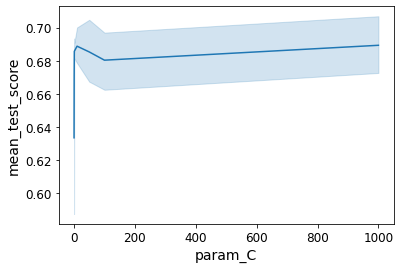

In [29]:
sns.lineplot(data=GridSearchResult_rbf_WeightedClean, x='param_C', y='mean_test_score')

<AxesSubplot:xlabel='param_class_weight', ylabel='mean_test_score'>

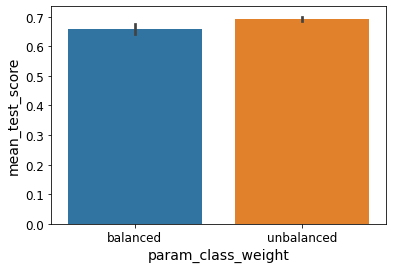

In [57]:
sns.barplot(data=GridSearchResult_rbf_WeightedClean, x='param_class_weight', y='mean_test_score')

<AxesSubplot:xlabel='param_C', ylabel='mean_test_score'>

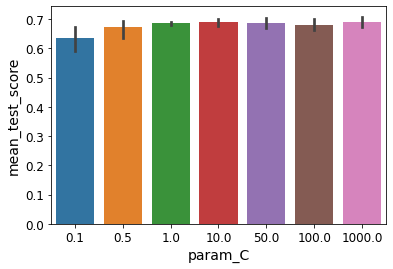

In [25]:
sns.barplot(data=GridSearchResult_rbf_WeightedClean, x='param_C', y='mean_test_score')

<AxesSubplot:xlabel='param_gamma', ylabel='mean_test_score'>

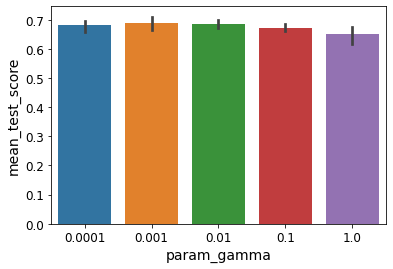

In [26]:
sns.barplot(data=GridSearchResult_rbf_WeightedClean, x='param_gamma', y='mean_test_score')

ConversionError: Failed to convert value(s) to axis units: 0     balanced
1     balanced
2     balanced
3     balanced
4     balanced
        ...   
65         NaN
66         NaN
67         NaN
68         NaN
69         NaN
Name: x, Length: 70, dtype: object

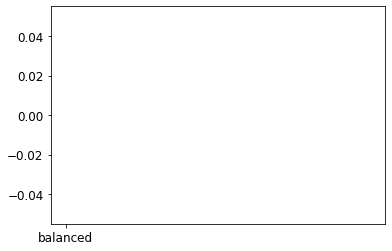

In [14]:
sns.lineplot(data=GridSearchResult_rbf_WeightedClean, x='param_class_weight', y='mean_test_score')

In [22]:
import plotly
import plotly.express as px

fig = px.scatter_3d(GridSearchResult_rbf_WeightedClean[['param_C','mean_test_score','param_gamma']],
                    x = 'param_C',
                    y = 'mean_test_score',
                    z = 'param_gamma',
                    opacity = 0.7)

fig.update_layout(margin = dict(l=0, r=0, b=0, t=0))

In [36]:
GridSearchResult_rbf_withoutCategorical = pd.read_csv('GridSearchResult_rbf_withoutCategorical.csv')

<AxesSubplot:xlabel='param_C', ylabel='mean_test_score'>

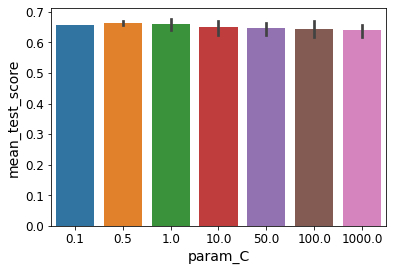

In [37]:
sns.barplot(data=GridSearchResult_rbf_withoutCategorical, x='param_C', y='mean_test_score')

<AxesSubplot:xlabel='param_gamma', ylabel='mean_test_score'>

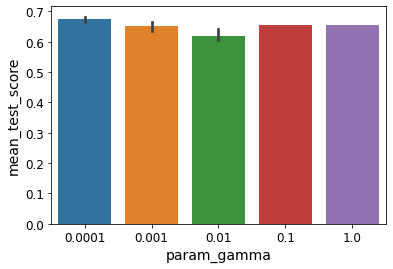

In [38]:
sns.barplot(data=GridSearchResult_rbf_withoutCategorical, x='param_gamma', y='mean_test_score')

In [27]:
GridSearchResult_lineal_WeightedClean = pd.read_csv('GridSearchResult_lineal_WeightedClean.csv')

<AxesSubplot:xlabel='param_C', ylabel='mean_test_score'>

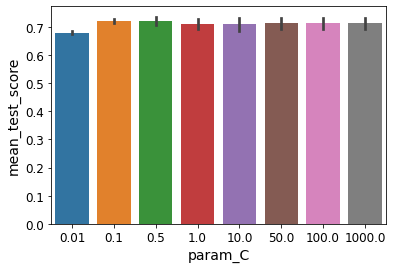

In [28]:
sns.barplot(data=GridSearchResult_lineal_WeightedClean, x='param_C', y='mean_test_score')

In [33]:
GridSearchResult_sig_WeightedClean = pd.read_csv('GridSearchResult_sig_WeightedClean.csv')

<AxesSubplot:xlabel='param_C', ylabel='mean_test_score'>

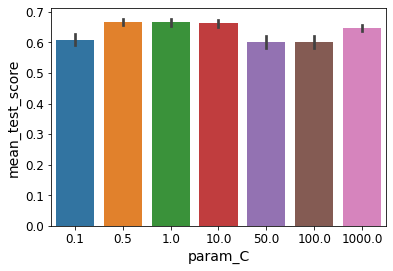

In [34]:
sns.barplot(data=GridSearchResult_sig_WeightedClean, x='param_C', y='mean_test_score')

<AxesSubplot:xlabel='param_gamma', ylabel='mean_test_score'>

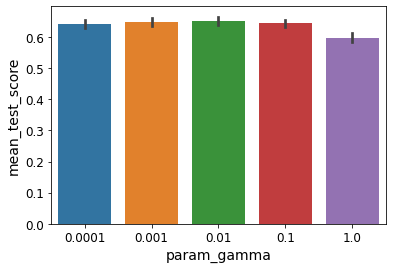

In [35]:
sns.barplot(data=GridSearchResult_sig_WeightedClean, x='param_gamma', y='mean_test_score')

In [ ]:
def plot_dataset(X, y, axes):
    plt.plot(X.iloc[:, 0][y==0], X.iloc[:, 1][y==0], "bs")
    plt.plot(X.iloc[:, 0][y==1], X.iloc[:, 1][y==1], "g^")
    plt.axis(axes)
    plt.grid(True, which='both')
    plt.xlabel(r"$x_1$", fontsize=20)
    plt.ylabel(r"$x_2$", fontsize=20, rotation=0)

def plot_predictions(clf, axes):
    x0s = np.array(train.adiposity)
    x1s = np.array(train.obesity)
    x0, x1 = np.meshgrid(x0s, x1s)
    X = np.c_[x0.ravel(), x1.ravel()]
    y_pred = clf.predict(X).reshape(x0.shape)
    y_decision = clf.decision_function(X).reshape(x0.shape)
    plt.contourf(x0, x1, y_decision, cmap=plt.cm.brg, alpha=0.1)
    plt.contourf(x0, x1, y_pred, cmap=plt.cm.brg, alpha=0.2)

plot_predictions(clf.best_estimator_, [0, 50, 10, 50])
plot_dataset(train, y_train, [0, 50, 10, 50])

save_fig("polynomial_svc_plot")
plt.show()

